# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [20]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

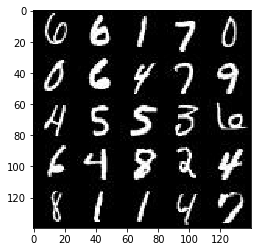

In [21]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

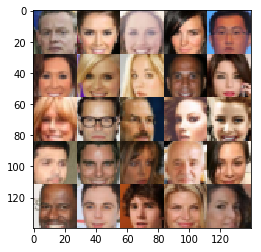

In [22]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [24]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return real, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [25]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    def leaky_relu(x, alpha=0.2):
        return tf.maximum(alpha * x, x)
    
    init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02, seed=1.0)
    kernel = 4
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        conv1 = tf.layers.conv2d(images, 64, kernel, strides=2, padding='same', kernel_initializer=init)
        conv1 = leaky_relu(conv1) #14x14x64
        
        conv2 = tf.layers.conv2d(conv1, 128, kernel, strides=2, padding='same', use_bias=False, kernel_initializer=init)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = leaky_relu(conv2) #7x7x128
        
        conv3 = tf.layers.conv2d(conv2, 256, kernel, strides=2, padding='same', use_bias=False, kernel_initializer=init)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = leaky_relu(conv3) #4x4x256

        flat = tf.reshape(conv3, [-1, 4*4*256])
        logits = tf.layers.dense(flat, 1, kernel_initializer=init)
        out = tf.sigmoid(logits)
        
        return out, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    def leaky_relu(x, alpha=0.2):
        return tf.maximum(alpha * x, x)
    
    init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02, seed=2.0)
    kernel = 4
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 2*2*1024, use_bias=False, kernel_initializer=init)
        x = tf.reshape(x, [-1, 2, 2, 1024])
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leaky_relu(x) #2*2*1024
        
        conv1 = tf.layers.conv2d_transpose(x, 512, kernel, strides=2, padding='same', use_bias=False, kernel_initializer=init)
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = leaky_relu(conv1) #4*4*512

        #output_size = (input_size - 1) * strides + kernel (because padding = valid)
        conv2 = tf.layers.conv2d_transpose(conv1, 256, kernel, strides=1, padding='valid', use_bias=False, kernel_initializer=init) 
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = leaky_relu(conv2) #7*7*256
        
        conv3 = tf.layers.conv2d_transpose(conv2, 128, kernel, strides=2, padding='same', use_bias=False, kernel_initializer=init)
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = leaky_relu(conv3) #14*14*128

        conv4 = tf.layers.conv2d_transpose(conv3, out_channel_dim, kernel, strides=2, padding='same', kernel_initializer=init)
        out = tf.tanh(conv4) #28*28*out_channel_dim
        
        return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9)) #smooth
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    losses = []
    steps = 0
    print_every = 10
    show_every = 100

    #tf.reset_default_graph()
    
    _, width, height, channels = data_shape
    
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
        
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch in get_batches(batch_size):
                steps += 1
                
                batch_images = batch * 2 #scale images to -1, 1 range (from -0.5 to 0.5) to match generator tanh output
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate, input_real: batch_images}) #why?

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict={input_z: batch_z})

                    print("Epoch {}/{}...Batch {}".format(epoch_i + 1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, channels, data_image_mode)
                
                saver.save(sess, './checkpoints/generator.ckpt')
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2...Batch 10 Discriminator Loss: 1.4087... Generator Loss: 0.4659
Epoch 1/2...Batch 20 Discriminator Loss: 2.9442... Generator Loss: 0.0804
Epoch 1/2...Batch 30 Discriminator Loss: 2.8645... Generator Loss: 0.1309
Epoch 1/2...Batch 40 Discriminator Loss: 2.4869... Generator Loss: 0.2074
Epoch 1/2...Batch 50 Discriminator Loss: 1.0540... Generator Loss: 0.8715
Epoch 1/2...Batch 60 Discriminator Loss: 1.2932... Generator Loss: 0.7017
Epoch 1/2...Batch 70 Discriminator Loss: 0.7975... Generator Loss: 1.5745
Epoch 1/2...Batch 80 Discriminator Loss: 0.6388... Generator Loss: 1.8523
Epoch 1/2...Batch 90 Discriminator Loss: 0.9299... Generator Loss: 0.9505
Epoch 1/2...Batch 100 Discriminator Loss: 0.7231... Generator Loss: 1.6216


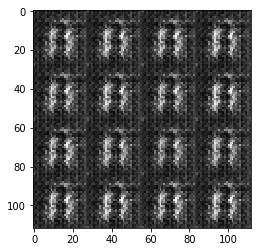

Epoch 1/2...Batch 110 Discriminator Loss: 0.6717... Generator Loss: 1.8264
Epoch 1/2...Batch 120 Discriminator Loss: 0.5705... Generator Loss: 2.2769
Epoch 1/2...Batch 130 Discriminator Loss: 0.9272... Generator Loss: 0.9725
Epoch 1/2...Batch 140 Discriminator Loss: 0.5883... Generator Loss: 2.0175
Epoch 1/2...Batch 150 Discriminator Loss: 0.7819... Generator Loss: 1.1702
Epoch 1/2...Batch 160 Discriminator Loss: 0.9931... Generator Loss: 0.8360
Epoch 1/2...Batch 170 Discriminator Loss: 0.7438... Generator Loss: 1.3848
Epoch 1/2...Batch 180 Discriminator Loss: 0.5319... Generator Loss: 2.8078
Epoch 1/2...Batch 190 Discriminator Loss: 0.6635... Generator Loss: 1.4641
Epoch 1/2...Batch 200 Discriminator Loss: 0.4281... Generator Loss: 2.8437


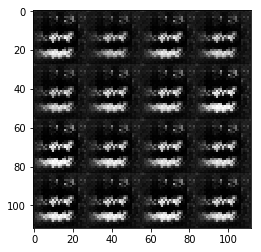

Epoch 1/2...Batch 210 Discriminator Loss: 0.6362... Generator Loss: 1.5589
Epoch 1/2...Batch 220 Discriminator Loss: 0.5649... Generator Loss: 2.6099
Epoch 1/2...Batch 230 Discriminator Loss: 0.4864... Generator Loss: 2.2203
Epoch 1/2...Batch 240 Discriminator Loss: 0.4899... Generator Loss: 3.1893
Epoch 1/2...Batch 250 Discriminator Loss: 0.5363... Generator Loss: 2.6649
Epoch 1/2...Batch 260 Discriminator Loss: 0.6852... Generator Loss: 3.9128
Epoch 1/2...Batch 270 Discriminator Loss: 0.6220... Generator Loss: 1.6120
Epoch 1/2...Batch 280 Discriminator Loss: 0.5519... Generator Loss: 2.3970
Epoch 1/2...Batch 290 Discriminator Loss: 0.4705... Generator Loss: 2.8348
Epoch 1/2...Batch 300 Discriminator Loss: 0.4611... Generator Loss: 2.5227


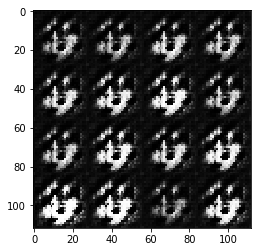

Epoch 1/2...Batch 310 Discriminator Loss: 0.5937... Generator Loss: 1.7611
Epoch 1/2...Batch 320 Discriminator Loss: 0.5021... Generator Loss: 2.7943
Epoch 1/2...Batch 330 Discriminator Loss: 0.6268... Generator Loss: 2.2083
Epoch 1/2...Batch 340 Discriminator Loss: 0.4846... Generator Loss: 2.3885
Epoch 1/2...Batch 350 Discriminator Loss: 0.5231... Generator Loss: 2.4394
Epoch 1/2...Batch 360 Discriminator Loss: 0.5697... Generator Loss: 2.1876
Epoch 1/2...Batch 370 Discriminator Loss: 0.5990... Generator Loss: 2.6374
Epoch 1/2...Batch 380 Discriminator Loss: 0.5965... Generator Loss: 1.7393
Epoch 1/2...Batch 390 Discriminator Loss: 0.3889... Generator Loss: 5.3303
Epoch 1/2...Batch 400 Discriminator Loss: 0.5837... Generator Loss: 1.7670


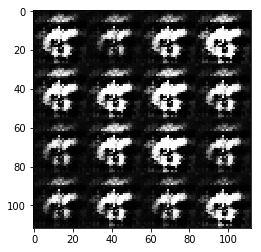

Epoch 1/2...Batch 410 Discriminator Loss: 0.4876... Generator Loss: 2.7924
Epoch 1/2...Batch 420 Discriminator Loss: 0.5312... Generator Loss: 2.1999
Epoch 1/2...Batch 430 Discriminator Loss: 0.7277... Generator Loss: 1.2480
Epoch 1/2...Batch 440 Discriminator Loss: 1.2088... Generator Loss: 6.7669
Epoch 1/2...Batch 450 Discriminator Loss: 0.7293... Generator Loss: 1.3041
Epoch 1/2...Batch 460 Discriminator Loss: 0.7235... Generator Loss: 2.1312
Epoch 1/2...Batch 470 Discriminator Loss: 0.8739... Generator Loss: 3.7618
Epoch 1/2...Batch 480 Discriminator Loss: 0.9081... Generator Loss: 4.2752
Epoch 1/2...Batch 490 Discriminator Loss: 0.7742... Generator Loss: 2.9198
Epoch 1/2...Batch 500 Discriminator Loss: 0.7428... Generator Loss: 3.5060


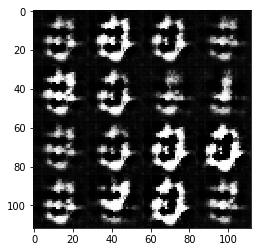

Epoch 1/2...Batch 510 Discriminator Loss: 0.6680... Generator Loss: 2.1219
Epoch 1/2...Batch 520 Discriminator Loss: 0.6462... Generator Loss: 1.7359
Epoch 1/2...Batch 530 Discriminator Loss: 0.9902... Generator Loss: 0.9374
Epoch 1/2...Batch 540 Discriminator Loss: 0.6249... Generator Loss: 1.9283
Epoch 1/2...Batch 550 Discriminator Loss: 0.5448... Generator Loss: 2.4331
Epoch 1/2...Batch 560 Discriminator Loss: 0.7440... Generator Loss: 1.6020
Epoch 1/2...Batch 570 Discriminator Loss: 0.5788... Generator Loss: 2.3379
Epoch 1/2...Batch 580 Discriminator Loss: 0.9079... Generator Loss: 2.7268
Epoch 1/2...Batch 590 Discriminator Loss: 0.6458... Generator Loss: 1.8020
Epoch 1/2...Batch 600 Discriminator Loss: 0.5617... Generator Loss: 2.2210


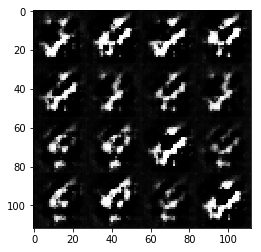

Epoch 1/2...Batch 610 Discriminator Loss: 0.9232... Generator Loss: 2.4842
Epoch 1/2...Batch 620 Discriminator Loss: 0.7106... Generator Loss: 1.7669
Epoch 1/2...Batch 630 Discriminator Loss: 0.9503... Generator Loss: 2.4851
Epoch 1/2...Batch 640 Discriminator Loss: 0.5799... Generator Loss: 2.3544
Epoch 1/2...Batch 650 Discriminator Loss: 0.8408... Generator Loss: 1.6405
Epoch 1/2...Batch 660 Discriminator Loss: 0.7907... Generator Loss: 1.4718
Epoch 1/2...Batch 670 Discriminator Loss: 0.8518... Generator Loss: 2.2751
Epoch 1/2...Batch 680 Discriminator Loss: 0.6535... Generator Loss: 2.3959
Epoch 1/2...Batch 690 Discriminator Loss: 0.6822... Generator Loss: 1.7505
Epoch 1/2...Batch 700 Discriminator Loss: 0.7729... Generator Loss: 2.0518


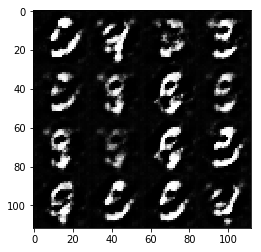

Epoch 1/2...Batch 710 Discriminator Loss: 0.6294... Generator Loss: 1.8363
Epoch 1/2...Batch 720 Discriminator Loss: 1.2358... Generator Loss: 0.5804
Epoch 1/2...Batch 730 Discriminator Loss: 0.7280... Generator Loss: 1.3777
Epoch 1/2...Batch 740 Discriminator Loss: 0.9525... Generator Loss: 2.8565
Epoch 1/2...Batch 750 Discriminator Loss: 0.6777... Generator Loss: 1.7316
Epoch 1/2...Batch 760 Discriminator Loss: 0.6832... Generator Loss: 1.7904
Epoch 1/2...Batch 770 Discriminator Loss: 0.8532... Generator Loss: 1.3144
Epoch 1/2...Batch 780 Discriminator Loss: 0.8573... Generator Loss: 1.4509
Epoch 1/2...Batch 790 Discriminator Loss: 0.6631... Generator Loss: 2.6098
Epoch 1/2...Batch 800 Discriminator Loss: 0.9426... Generator Loss: 4.2253


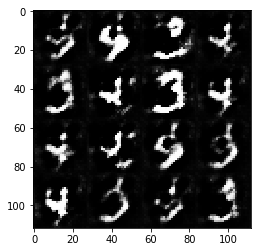

Epoch 1/2...Batch 810 Discriminator Loss: 0.7432... Generator Loss: 1.4796
Epoch 1/2...Batch 820 Discriminator Loss: 0.8414... Generator Loss: 1.1174
Epoch 1/2...Batch 830 Discriminator Loss: 0.7173... Generator Loss: 1.3628
Epoch 1/2...Batch 840 Discriminator Loss: 0.6298... Generator Loss: 2.7520
Epoch 1/2...Batch 850 Discriminator Loss: 0.7187... Generator Loss: 1.4683
Epoch 1/2...Batch 860 Discriminator Loss: 0.6020... Generator Loss: 1.9067
Epoch 1/2...Batch 870 Discriminator Loss: 0.5835... Generator Loss: 2.1264
Epoch 1/2...Batch 880 Discriminator Loss: 0.6908... Generator Loss: 1.4330
Epoch 1/2...Batch 890 Discriminator Loss: 0.8567... Generator Loss: 1.2350
Epoch 1/2...Batch 900 Discriminator Loss: 0.6438... Generator Loss: 2.2569


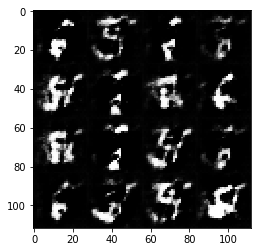

Epoch 1/2...Batch 910 Discriminator Loss: 0.7627... Generator Loss: 1.3776
Epoch 1/2...Batch 920 Discriminator Loss: 0.6483... Generator Loss: 2.5978
Epoch 1/2...Batch 930 Discriminator Loss: 0.6732... Generator Loss: 2.2531
Epoch 1/2...Batch 940 Discriminator Loss: 0.7551... Generator Loss: 1.3146
Epoch 1/2...Batch 950 Discriminator Loss: 1.0159... Generator Loss: 0.8700
Epoch 1/2...Batch 960 Discriminator Loss: 0.6657... Generator Loss: 1.7485
Epoch 1/2...Batch 970 Discriminator Loss: 0.5480... Generator Loss: 2.2784
Epoch 1/2...Batch 980 Discriminator Loss: 0.5915... Generator Loss: 1.9538
Epoch 1/2...Batch 990 Discriminator Loss: 0.5986... Generator Loss: 3.0442
Epoch 1/2...Batch 1000 Discriminator Loss: 0.6530... Generator Loss: 2.1349


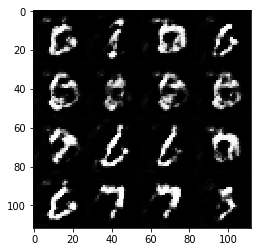

Epoch 1/2...Batch 1010 Discriminator Loss: 0.6156... Generator Loss: 2.4047
Epoch 1/2...Batch 1020 Discriminator Loss: 0.5930... Generator Loss: 1.9658
Epoch 1/2...Batch 1030 Discriminator Loss: 0.7722... Generator Loss: 2.6336
Epoch 1/2...Batch 1040 Discriminator Loss: 0.6573... Generator Loss: 2.1724
Epoch 1/2...Batch 1050 Discriminator Loss: 0.6724... Generator Loss: 1.9231
Epoch 1/2...Batch 1060 Discriminator Loss: 1.0897... Generator Loss: 0.7113
Epoch 1/2...Batch 1070 Discriminator Loss: 0.8348... Generator Loss: 1.2668
Epoch 1/2...Batch 1080 Discriminator Loss: 0.8867... Generator Loss: 1.2246
Epoch 1/2...Batch 1090 Discriminator Loss: 0.8008... Generator Loss: 1.4364
Epoch 1/2...Batch 1100 Discriminator Loss: 0.7054... Generator Loss: 1.6696


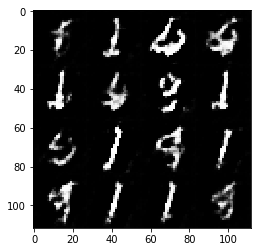

Epoch 1/2...Batch 1110 Discriminator Loss: 0.6432... Generator Loss: 2.7136
Epoch 1/2...Batch 1120 Discriminator Loss: 1.0312... Generator Loss: 1.0853
Epoch 1/2...Batch 1130 Discriminator Loss: 0.6485... Generator Loss: 1.6951
Epoch 1/2...Batch 1140 Discriminator Loss: 0.7680... Generator Loss: 2.0189
Epoch 1/2...Batch 1150 Discriminator Loss: 0.8582... Generator Loss: 1.2580
Epoch 1/2...Batch 1160 Discriminator Loss: 0.8503... Generator Loss: 3.0326
Epoch 1/2...Batch 1170 Discriminator Loss: 0.7427... Generator Loss: 2.1175
Epoch 1/2...Batch 1180 Discriminator Loss: 0.6656... Generator Loss: 1.5470
Epoch 1/2...Batch 1190 Discriminator Loss: 1.3805... Generator Loss: 4.9620
Epoch 1/2...Batch 1200 Discriminator Loss: 0.8038... Generator Loss: 1.4419


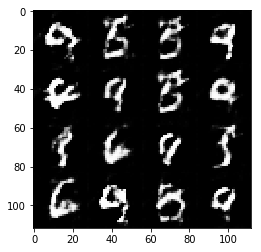

Epoch 1/2...Batch 1210 Discriminator Loss: 0.8183... Generator Loss: 2.1654
Epoch 1/2...Batch 1220 Discriminator Loss: 0.9001... Generator Loss: 3.1727
Epoch 1/2...Batch 1230 Discriminator Loss: 1.0137... Generator Loss: 0.9315
Epoch 1/2...Batch 1240 Discriminator Loss: 1.2845... Generator Loss: 0.5898
Epoch 1/2...Batch 1250 Discriminator Loss: 0.7545... Generator Loss: 2.7916
Epoch 1/2...Batch 1260 Discriminator Loss: 1.0580... Generator Loss: 3.3577
Epoch 1/2...Batch 1270 Discriminator Loss: 0.6867... Generator Loss: 2.2649
Epoch 1/2...Batch 1280 Discriminator Loss: 1.0801... Generator Loss: 0.7928
Epoch 1/2...Batch 1290 Discriminator Loss: 0.8874... Generator Loss: 3.5714
Epoch 1/2...Batch 1300 Discriminator Loss: 0.9404... Generator Loss: 1.8390


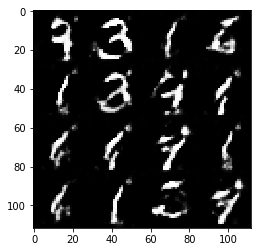

Epoch 1/2...Batch 1310 Discriminator Loss: 0.9150... Generator Loss: 2.7671
Epoch 1/2...Batch 1320 Discriminator Loss: 0.7910... Generator Loss: 1.2746
Epoch 1/2...Batch 1330 Discriminator Loss: 0.7556... Generator Loss: 1.3388
Epoch 1/2...Batch 1340 Discriminator Loss: 1.1329... Generator Loss: 0.7160
Epoch 1/2...Batch 1350 Discriminator Loss: 0.7271... Generator Loss: 1.4306
Epoch 1/2...Batch 1360 Discriminator Loss: 0.7700... Generator Loss: 1.6599
Epoch 1/2...Batch 1370 Discriminator Loss: 0.7021... Generator Loss: 1.7555
Epoch 1/2...Batch 1380 Discriminator Loss: 0.8948... Generator Loss: 1.2143
Epoch 1/2...Batch 1390 Discriminator Loss: 0.8551... Generator Loss: 1.9862
Epoch 1/2...Batch 1400 Discriminator Loss: 0.8599... Generator Loss: 1.2231


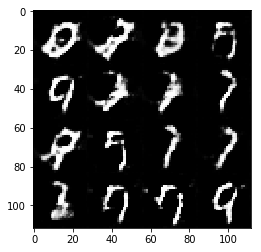

Epoch 1/2...Batch 1410 Discriminator Loss: 0.7938... Generator Loss: 1.2947
Epoch 1/2...Batch 1420 Discriminator Loss: 0.6907... Generator Loss: 1.9921
Epoch 1/2...Batch 1430 Discriminator Loss: 0.7061... Generator Loss: 1.7275
Epoch 1/2...Batch 1440 Discriminator Loss: 0.6455... Generator Loss: 1.9488
Epoch 1/2...Batch 1450 Discriminator Loss: 1.3851... Generator Loss: 4.6904
Epoch 1/2...Batch 1460 Discriminator Loss: 0.7762... Generator Loss: 2.0337
Epoch 1/2...Batch 1470 Discriminator Loss: 0.8118... Generator Loss: 1.2703
Epoch 1/2...Batch 1480 Discriminator Loss: 0.6989... Generator Loss: 1.6578
Epoch 1/2...Batch 1490 Discriminator Loss: 0.7068... Generator Loss: 1.6716
Epoch 1/2...Batch 1500 Discriminator Loss: 1.4376... Generator Loss: 0.5211


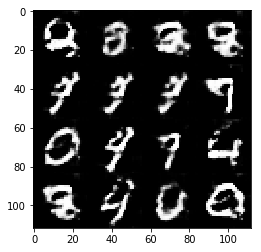

Epoch 1/2...Batch 1510 Discriminator Loss: 0.8495... Generator Loss: 2.7943
Epoch 1/2...Batch 1520 Discriminator Loss: 0.6818... Generator Loss: 1.6243
Epoch 1/2...Batch 1530 Discriminator Loss: 0.7684... Generator Loss: 1.4734
Epoch 1/2...Batch 1540 Discriminator Loss: 0.7316... Generator Loss: 2.3362
Epoch 1/2...Batch 1550 Discriminator Loss: 0.8831... Generator Loss: 1.0816
Epoch 1/2...Batch 1560 Discriminator Loss: 0.6864... Generator Loss: 1.9858
Epoch 1/2...Batch 1570 Discriminator Loss: 1.0585... Generator Loss: 0.8205
Epoch 1/2...Batch 1580 Discriminator Loss: 0.7641... Generator Loss: 1.3556
Epoch 1/2...Batch 1590 Discriminator Loss: 0.7449... Generator Loss: 2.9149
Epoch 1/2...Batch 1600 Discriminator Loss: 0.9920... Generator Loss: 1.0352


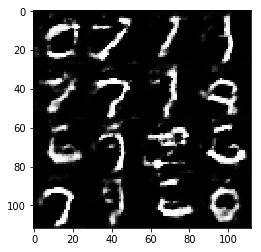

Epoch 1/2...Batch 1610 Discriminator Loss: 0.9689... Generator Loss: 0.9869
Epoch 1/2...Batch 1620 Discriminator Loss: 0.7532... Generator Loss: 1.6299
Epoch 1/2...Batch 1630 Discriminator Loss: 0.8092... Generator Loss: 1.1634
Epoch 1/2...Batch 1640 Discriminator Loss: 1.2526... Generator Loss: 0.6244
Epoch 1/2...Batch 1650 Discriminator Loss: 0.8601... Generator Loss: 1.1517
Epoch 1/2...Batch 1660 Discriminator Loss: 0.8546... Generator Loss: 1.1856
Epoch 1/2...Batch 1670 Discriminator Loss: 0.8973... Generator Loss: 1.0702
Epoch 1/2...Batch 1680 Discriminator Loss: 0.8129... Generator Loss: 1.1728
Epoch 1/2...Batch 1690 Discriminator Loss: 1.2570... Generator Loss: 0.7498
Epoch 1/2...Batch 1700 Discriminator Loss: 0.8135... Generator Loss: 1.1359


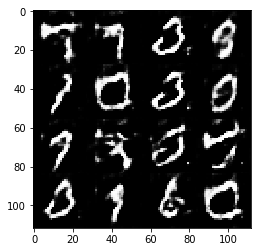

Epoch 1/2...Batch 1710 Discriminator Loss: 0.7282... Generator Loss: 1.6411
Epoch 1/2...Batch 1720 Discriminator Loss: 0.8807... Generator Loss: 1.3416
Epoch 1/2...Batch 1730 Discriminator Loss: 0.8897... Generator Loss: 1.0680
Epoch 1/2...Batch 1740 Discriminator Loss: 1.2084... Generator Loss: 2.2558
Epoch 1/2...Batch 1750 Discriminator Loss: 1.0740... Generator Loss: 2.5031
Epoch 1/2...Batch 1760 Discriminator Loss: 0.8230... Generator Loss: 1.3180
Epoch 1/2...Batch 1770 Discriminator Loss: 0.7728... Generator Loss: 1.4174
Epoch 1/2...Batch 1780 Discriminator Loss: 1.0033... Generator Loss: 0.7898
Epoch 1/2...Batch 1790 Discriminator Loss: 0.7720... Generator Loss: 1.4860
Epoch 1/2...Batch 1800 Discriminator Loss: 0.9904... Generator Loss: 0.9189


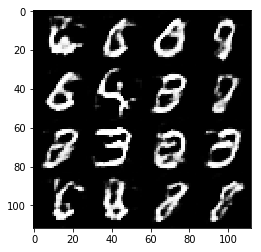

Epoch 1/2...Batch 1810 Discriminator Loss: 0.7650... Generator Loss: 1.2905
Epoch 1/2...Batch 1820 Discriminator Loss: 0.9060... Generator Loss: 2.7993
Epoch 1/2...Batch 1830 Discriminator Loss: 0.9199... Generator Loss: 2.3283
Epoch 1/2...Batch 1840 Discriminator Loss: 0.9098... Generator Loss: 0.9449
Epoch 1/2...Batch 1850 Discriminator Loss: 0.8690... Generator Loss: 1.0681
Epoch 1/2...Batch 1860 Discriminator Loss: 0.7836... Generator Loss: 1.3399
Epoch 1/2...Batch 1870 Discriminator Loss: 1.4403... Generator Loss: 0.4705
Epoch 2/2...Batch 1880 Discriminator Loss: 1.6671... Generator Loss: 0.4148
Epoch 2/2...Batch 1890 Discriminator Loss: 0.8532... Generator Loss: 1.2888
Epoch 2/2...Batch 1900 Discriminator Loss: 0.8212... Generator Loss: 1.3172


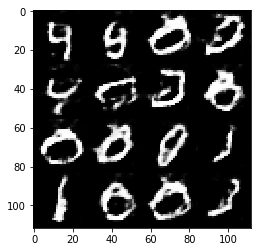

Epoch 2/2...Batch 1910 Discriminator Loss: 0.8978... Generator Loss: 0.9764
Epoch 2/2...Batch 1920 Discriminator Loss: 0.8367... Generator Loss: 1.2813
Epoch 2/2...Batch 1930 Discriminator Loss: 1.0169... Generator Loss: 0.8676
Epoch 2/2...Batch 1940 Discriminator Loss: 0.8191... Generator Loss: 1.3164
Epoch 2/2...Batch 1950 Discriminator Loss: 1.1481... Generator Loss: 0.7617
Epoch 2/2...Batch 1960 Discriminator Loss: 1.1116... Generator Loss: 0.7111
Epoch 2/2...Batch 1970 Discriminator Loss: 0.9707... Generator Loss: 0.8694
Epoch 2/2...Batch 1980 Discriminator Loss: 1.0164... Generator Loss: 0.9077
Epoch 2/2...Batch 1990 Discriminator Loss: 1.2933... Generator Loss: 0.5805
Epoch 2/2...Batch 2000 Discriminator Loss: 0.9603... Generator Loss: 0.8860


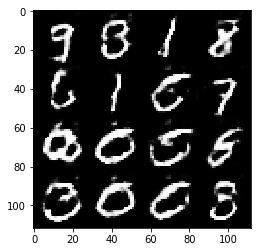

Epoch 2/2...Batch 2010 Discriminator Loss: 1.0994... Generator Loss: 0.7385
Epoch 2/2...Batch 2020 Discriminator Loss: 0.7509... Generator Loss: 1.2903
Epoch 2/2...Batch 2030 Discriminator Loss: 0.6846... Generator Loss: 1.9240
Epoch 2/2...Batch 2040 Discriminator Loss: 0.8949... Generator Loss: 1.0151
Epoch 2/2...Batch 2050 Discriminator Loss: 0.9422... Generator Loss: 0.9785
Epoch 2/2...Batch 2060 Discriminator Loss: 1.0647... Generator Loss: 0.7717
Epoch 2/2...Batch 2070 Discriminator Loss: 1.2620... Generator Loss: 0.5856
Epoch 2/2...Batch 2080 Discriminator Loss: 0.9366... Generator Loss: 1.3648
Epoch 2/2...Batch 2090 Discriminator Loss: 0.9690... Generator Loss: 0.8325
Epoch 2/2...Batch 2100 Discriminator Loss: 0.9159... Generator Loss: 1.4720


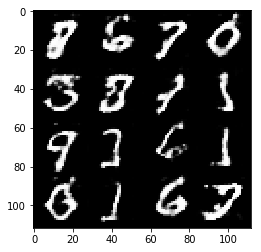

Epoch 2/2...Batch 2110 Discriminator Loss: 0.9149... Generator Loss: 1.1024
Epoch 2/2...Batch 2120 Discriminator Loss: 0.7088... Generator Loss: 1.5142
Epoch 2/2...Batch 2130 Discriminator Loss: 0.8140... Generator Loss: 1.2956
Epoch 2/2...Batch 2140 Discriminator Loss: 0.9119... Generator Loss: 1.1371
Epoch 2/2...Batch 2150 Discriminator Loss: 1.1269... Generator Loss: 0.6886
Epoch 2/2...Batch 2160 Discriminator Loss: 0.9431... Generator Loss: 1.5004
Epoch 2/2...Batch 2170 Discriminator Loss: 1.9524... Generator Loss: 0.2995
Epoch 2/2...Batch 2180 Discriminator Loss: 1.0571... Generator Loss: 1.0728
Epoch 2/2...Batch 2190 Discriminator Loss: 0.8593... Generator Loss: 1.1498
Epoch 2/2...Batch 2200 Discriminator Loss: 0.8835... Generator Loss: 1.8490


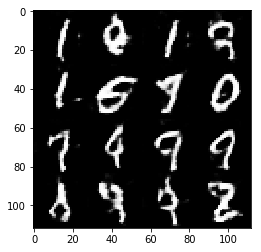

Epoch 2/2...Batch 2210 Discriminator Loss: 0.9097... Generator Loss: 1.4144
Epoch 2/2...Batch 2220 Discriminator Loss: 1.2153... Generator Loss: 0.6652
Epoch 2/2...Batch 2230 Discriminator Loss: 1.3191... Generator Loss: 2.4161
Epoch 2/2...Batch 2240 Discriminator Loss: 0.9979... Generator Loss: 1.6465
Epoch 2/2...Batch 2250 Discriminator Loss: 1.0202... Generator Loss: 0.8278
Epoch 2/2...Batch 2260 Discriminator Loss: 0.8221... Generator Loss: 1.5064
Epoch 2/2...Batch 2270 Discriminator Loss: 0.7395... Generator Loss: 1.6149
Epoch 2/2...Batch 2280 Discriminator Loss: 1.2868... Generator Loss: 2.5763
Epoch 2/2...Batch 2290 Discriminator Loss: 0.7105... Generator Loss: 1.3881
Epoch 2/2...Batch 2300 Discriminator Loss: 0.8947... Generator Loss: 1.1334


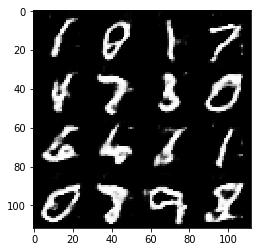

Epoch 2/2...Batch 2310 Discriminator Loss: 0.7022... Generator Loss: 1.8586
Epoch 2/2...Batch 2320 Discriminator Loss: 1.7134... Generator Loss: 0.3449
Epoch 2/2...Batch 2330 Discriminator Loss: 0.8835... Generator Loss: 1.7473
Epoch 2/2...Batch 2340 Discriminator Loss: 1.2293... Generator Loss: 0.7086
Epoch 2/2...Batch 2350 Discriminator Loss: 0.7537... Generator Loss: 1.2596
Epoch 2/2...Batch 2360 Discriminator Loss: 0.9895... Generator Loss: 0.8481
Epoch 2/2...Batch 2370 Discriminator Loss: 0.8722... Generator Loss: 1.1055
Epoch 2/2...Batch 2380 Discriminator Loss: 0.9176... Generator Loss: 1.1723
Epoch 2/2...Batch 2390 Discriminator Loss: 0.9541... Generator Loss: 1.2904
Epoch 2/2...Batch 2400 Discriminator Loss: 0.8635... Generator Loss: 1.2115


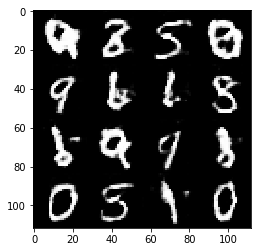

Epoch 2/2...Batch 2410 Discriminator Loss: 0.7943... Generator Loss: 1.2692
Epoch 2/2...Batch 2420 Discriminator Loss: 0.9866... Generator Loss: 0.8476
Epoch 2/2...Batch 2430 Discriminator Loss: 0.8371... Generator Loss: 1.0607
Epoch 2/2...Batch 2440 Discriminator Loss: 1.3992... Generator Loss: 0.4668
Epoch 2/2...Batch 2450 Discriminator Loss: 0.9807... Generator Loss: 0.9348
Epoch 2/2...Batch 2460 Discriminator Loss: 0.7255... Generator Loss: 1.4799
Epoch 2/2...Batch 2470 Discriminator Loss: 0.9961... Generator Loss: 0.8266
Epoch 2/2...Batch 2480 Discriminator Loss: 0.8365... Generator Loss: 1.1862
Epoch 2/2...Batch 2490 Discriminator Loss: 0.8817... Generator Loss: 1.1743
Epoch 2/2...Batch 2500 Discriminator Loss: 0.9848... Generator Loss: 0.9396


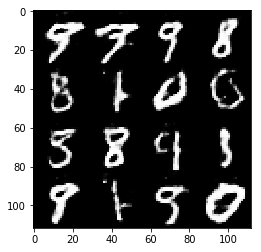

Epoch 2/2...Batch 2510 Discriminator Loss: 0.6535... Generator Loss: 1.7987
Epoch 2/2...Batch 2520 Discriminator Loss: 1.4120... Generator Loss: 0.4603
Epoch 2/2...Batch 2530 Discriminator Loss: 0.6671... Generator Loss: 1.7529
Epoch 2/2...Batch 2540 Discriminator Loss: 0.8635... Generator Loss: 1.0336
Epoch 2/2...Batch 2550 Discriminator Loss: 1.2805... Generator Loss: 0.5462
Epoch 2/2...Batch 2560 Discriminator Loss: 0.7820... Generator Loss: 1.2647
Epoch 2/2...Batch 2570 Discriminator Loss: 0.8711... Generator Loss: 1.1128
Epoch 2/2...Batch 2580 Discriminator Loss: 1.0545... Generator Loss: 1.5169
Epoch 2/2...Batch 2590 Discriminator Loss: 0.9345... Generator Loss: 1.9230
Epoch 2/2...Batch 2600 Discriminator Loss: 0.7337... Generator Loss: 1.5402


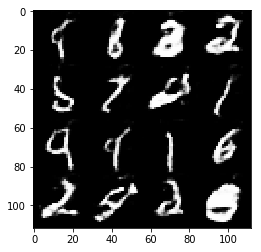

Epoch 2/2...Batch 2610 Discriminator Loss: 0.7055... Generator Loss: 1.6294
Epoch 2/2...Batch 2620 Discriminator Loss: 0.9557... Generator Loss: 0.9071
Epoch 2/2...Batch 2630 Discriminator Loss: 1.3848... Generator Loss: 0.5467
Epoch 2/2...Batch 2640 Discriminator Loss: 1.0492... Generator Loss: 0.8575
Epoch 2/2...Batch 2650 Discriminator Loss: 0.8067... Generator Loss: 1.2358
Epoch 2/2...Batch 2660 Discriminator Loss: 1.2295... Generator Loss: 0.6148
Epoch 2/2...Batch 2670 Discriminator Loss: 0.8389... Generator Loss: 1.4705
Epoch 2/2...Batch 2680 Discriminator Loss: 0.8572... Generator Loss: 0.9929
Epoch 2/2...Batch 2690 Discriminator Loss: 1.2666... Generator Loss: 0.5783
Epoch 2/2...Batch 2700 Discriminator Loss: 0.7508... Generator Loss: 1.9223


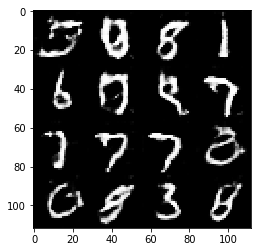

Epoch 2/2...Batch 2710 Discriminator Loss: 0.8379... Generator Loss: 2.2869
Epoch 2/2...Batch 2720 Discriminator Loss: 1.0401... Generator Loss: 0.8172
Epoch 2/2...Batch 2730 Discriminator Loss: 0.7376... Generator Loss: 1.5678
Epoch 2/2...Batch 2740 Discriminator Loss: 0.8365... Generator Loss: 1.2683
Epoch 2/2...Batch 2750 Discriminator Loss: 0.7358... Generator Loss: 1.4073
Epoch 2/2...Batch 2760 Discriminator Loss: 0.8848... Generator Loss: 1.0627
Epoch 2/2...Batch 2770 Discriminator Loss: 0.8405... Generator Loss: 1.2460
Epoch 2/2...Batch 2780 Discriminator Loss: 0.8124... Generator Loss: 1.1665
Epoch 2/2...Batch 2790 Discriminator Loss: 0.9084... Generator Loss: 0.9988
Epoch 2/2...Batch 2800 Discriminator Loss: 0.9846... Generator Loss: 0.8266


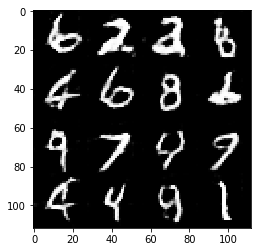

Epoch 2/2...Batch 2810 Discriminator Loss: 1.0071... Generator Loss: 0.8762
Epoch 2/2...Batch 2820 Discriminator Loss: 1.0911... Generator Loss: 2.1641
Epoch 2/2...Batch 2830 Discriminator Loss: 1.3900... Generator Loss: 0.5004
Epoch 2/2...Batch 2840 Discriminator Loss: 0.7775... Generator Loss: 1.4101
Epoch 2/2...Batch 2850 Discriminator Loss: 0.8204... Generator Loss: 2.2839
Epoch 2/2...Batch 2860 Discriminator Loss: 0.8728... Generator Loss: 0.9627
Epoch 2/2...Batch 2870 Discriminator Loss: 0.6800... Generator Loss: 1.8729
Epoch 2/2...Batch 2880 Discriminator Loss: 0.9680... Generator Loss: 0.8891
Epoch 2/2...Batch 2890 Discriminator Loss: 0.7687... Generator Loss: 1.9499
Epoch 2/2...Batch 2900 Discriminator Loss: 0.6521... Generator Loss: 1.4807


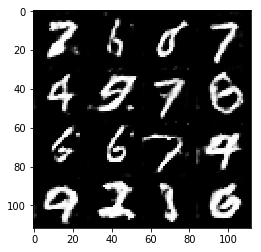

Epoch 2/2...Batch 2910 Discriminator Loss: 0.7383... Generator Loss: 1.3049
Epoch 2/2...Batch 2920 Discriminator Loss: 0.6750... Generator Loss: 1.8855
Epoch 2/2...Batch 2930 Discriminator Loss: 0.8962... Generator Loss: 0.9721
Epoch 2/2...Batch 2940 Discriminator Loss: 1.0126... Generator Loss: 0.8919
Epoch 2/2...Batch 2950 Discriminator Loss: 0.7981... Generator Loss: 1.7360
Epoch 2/2...Batch 2960 Discriminator Loss: 0.9431... Generator Loss: 0.9441
Epoch 2/2...Batch 2970 Discriminator Loss: 0.9375... Generator Loss: 1.1285
Epoch 2/2...Batch 2980 Discriminator Loss: 1.3342... Generator Loss: 0.5282
Epoch 2/2...Batch 2990 Discriminator Loss: 1.1025... Generator Loss: 0.7627
Epoch 2/2...Batch 3000 Discriminator Loss: 1.1792... Generator Loss: 0.6326


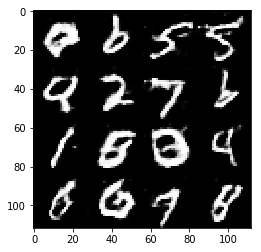

Epoch 2/2...Batch 3010 Discriminator Loss: 0.8773... Generator Loss: 0.9577
Epoch 2/2...Batch 3020 Discriminator Loss: 0.8711... Generator Loss: 1.0002
Epoch 2/2...Batch 3030 Discriminator Loss: 0.6885... Generator Loss: 1.6761
Epoch 2/2...Batch 3040 Discriminator Loss: 0.9684... Generator Loss: 2.6680
Epoch 2/2...Batch 3050 Discriminator Loss: 0.9151... Generator Loss: 0.9568
Epoch 2/2...Batch 3060 Discriminator Loss: 1.6978... Generator Loss: 0.3430
Epoch 2/2...Batch 3070 Discriminator Loss: 0.6676... Generator Loss: 2.0880
Epoch 2/2...Batch 3080 Discriminator Loss: 1.0645... Generator Loss: 1.0591
Epoch 2/2...Batch 3090 Discriminator Loss: 0.8540... Generator Loss: 1.2415
Epoch 2/2...Batch 3100 Discriminator Loss: 0.8375... Generator Loss: 1.1237


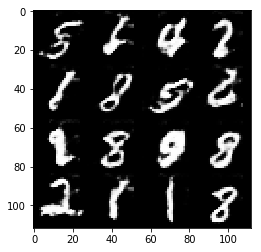

Epoch 2/2...Batch 3110 Discriminator Loss: 0.7511... Generator Loss: 1.4124
Epoch 2/2...Batch 3120 Discriminator Loss: 0.8038... Generator Loss: 1.1809
Epoch 2/2...Batch 3130 Discriminator Loss: 1.1148... Generator Loss: 0.6911
Epoch 2/2...Batch 3140 Discriminator Loss: 1.2973... Generator Loss: 0.5767
Epoch 2/2...Batch 3150 Discriminator Loss: 0.8148... Generator Loss: 1.2426
Epoch 2/2...Batch 3160 Discriminator Loss: 0.6678... Generator Loss: 1.7719
Epoch 2/2...Batch 3170 Discriminator Loss: 1.2070... Generator Loss: 0.6457
Epoch 2/2...Batch 3180 Discriminator Loss: 0.9243... Generator Loss: 0.9783
Epoch 2/2...Batch 3190 Discriminator Loss: 0.8039... Generator Loss: 2.1802
Epoch 2/2...Batch 3200 Discriminator Loss: 0.8621... Generator Loss: 1.4968


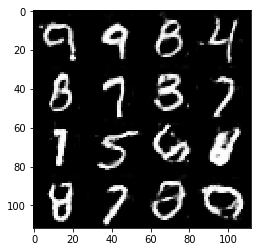

Epoch 2/2...Batch 3210 Discriminator Loss: 0.9264... Generator Loss: 0.9152
Epoch 2/2...Batch 3220 Discriminator Loss: 0.7538... Generator Loss: 1.4728
Epoch 2/2...Batch 3230 Discriminator Loss: 0.7873... Generator Loss: 1.1354
Epoch 2/2...Batch 3240 Discriminator Loss: 1.0636... Generator Loss: 0.7267
Epoch 2/2...Batch 3250 Discriminator Loss: 0.7608... Generator Loss: 1.2546
Epoch 2/2...Batch 3260 Discriminator Loss: 0.7532... Generator Loss: 2.1028
Epoch 2/2...Batch 3270 Discriminator Loss: 0.7538... Generator Loss: 1.2267
Epoch 2/2...Batch 3280 Discriminator Loss: 1.4179... Generator Loss: 3.2007
Epoch 2/2...Batch 3290 Discriminator Loss: 1.1202... Generator Loss: 0.8521
Epoch 2/2...Batch 3300 Discriminator Loss: 1.2833... Generator Loss: 0.5865


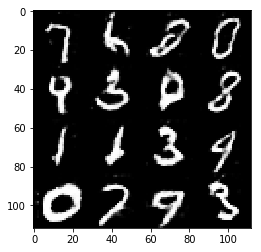

Epoch 2/2...Batch 3310 Discriminator Loss: 0.7591... Generator Loss: 1.2275
Epoch 2/2...Batch 3320 Discriminator Loss: 0.8482... Generator Loss: 1.1931
Epoch 2/2...Batch 3330 Discriminator Loss: 0.7334... Generator Loss: 1.8016
Epoch 2/2...Batch 3340 Discriminator Loss: 0.7052... Generator Loss: 1.4271
Epoch 2/2...Batch 3350 Discriminator Loss: 0.7341... Generator Loss: 1.4258
Epoch 2/2...Batch 3360 Discriminator Loss: 1.2910... Generator Loss: 0.6095
Epoch 2/2...Batch 3370 Discriminator Loss: 0.7694... Generator Loss: 1.2177
Epoch 2/2...Batch 3380 Discriminator Loss: 0.6756... Generator Loss: 1.5395
Epoch 2/2...Batch 3390 Discriminator Loss: 0.7590... Generator Loss: 1.1873
Epoch 2/2...Batch 3400 Discriminator Loss: 0.7454... Generator Loss: 1.3097


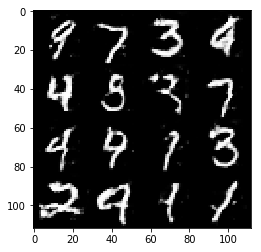

Epoch 2/2...Batch 3410 Discriminator Loss: 0.8052... Generator Loss: 1.0819
Epoch 2/2...Batch 3420 Discriminator Loss: 0.9511... Generator Loss: 1.5506
Epoch 2/2...Batch 3430 Discriminator Loss: 1.3364... Generator Loss: 0.5426
Epoch 2/2...Batch 3440 Discriminator Loss: 0.7049... Generator Loss: 1.6294
Epoch 2/2...Batch 3450 Discriminator Loss: 0.8241... Generator Loss: 1.1501
Epoch 2/2...Batch 3460 Discriminator Loss: 0.7114... Generator Loss: 1.4471
Epoch 2/2...Batch 3470 Discriminator Loss: 0.8777... Generator Loss: 1.0515
Epoch 2/2...Batch 3480 Discriminator Loss: 0.6457... Generator Loss: 1.5296
Epoch 2/2...Batch 3490 Discriminator Loss: 0.8045... Generator Loss: 1.2217
Epoch 2/2...Batch 3500 Discriminator Loss: 0.9943... Generator Loss: 0.9260


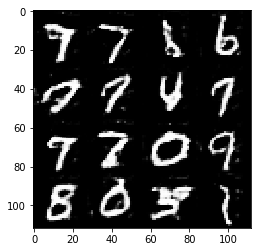

Epoch 2/2...Batch 3510 Discriminator Loss: 1.4619... Generator Loss: 2.2082
Epoch 2/2...Batch 3520 Discriminator Loss: 1.0240... Generator Loss: 0.8681
Epoch 2/2...Batch 3530 Discriminator Loss: 0.7467... Generator Loss: 1.8330
Epoch 2/2...Batch 3540 Discriminator Loss: 0.6813... Generator Loss: 1.4527
Epoch 2/2...Batch 3550 Discriminator Loss: 0.7024... Generator Loss: 1.5947
Epoch 2/2...Batch 3560 Discriminator Loss: 0.7836... Generator Loss: 1.1541
Epoch 2/2...Batch 3570 Discriminator Loss: 0.8273... Generator Loss: 1.1230
Epoch 2/2...Batch 3580 Discriminator Loss: 0.8642... Generator Loss: 2.2549
Epoch 2/2...Batch 3590 Discriminator Loss: 0.7383... Generator Loss: 1.7017
Epoch 2/2...Batch 3600 Discriminator Loss: 0.7253... Generator Loss: 1.4278


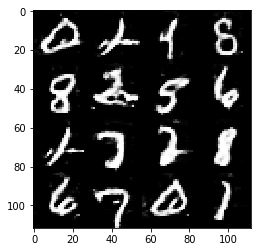

Epoch 2/2...Batch 3610 Discriminator Loss: 0.9378... Generator Loss: 0.8821
Epoch 2/2...Batch 3620 Discriminator Loss: 0.6541... Generator Loss: 1.6143
Epoch 2/2...Batch 3630 Discriminator Loss: 0.9243... Generator Loss: 0.9123
Epoch 2/2...Batch 3640 Discriminator Loss: 0.7627... Generator Loss: 1.1880
Epoch 2/2...Batch 3650 Discriminator Loss: 0.7623... Generator Loss: 1.2138
Epoch 2/2...Batch 3660 Discriminator Loss: 0.5579... Generator Loss: 2.2286
Epoch 2/2...Batch 3670 Discriminator Loss: 1.6497... Generator Loss: 0.4591
Epoch 2/2...Batch 3680 Discriminator Loss: 0.7692... Generator Loss: 1.8506


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1...Batch 10 Discriminator Loss: 1.9859... Generator Loss: 0.3483
Epoch 1/1...Batch 20 Discriminator Loss: 0.9273... Generator Loss: 1.9880
Epoch 1/1...Batch 30 Discriminator Loss: 1.0641... Generator Loss: 2.0966
Epoch 1/1...Batch 40 Discriminator Loss: 1.5093... Generator Loss: 0.5252
Epoch 1/1...Batch 50 Discriminator Loss: 0.6907... Generator Loss: 2.3247
Epoch 1/1...Batch 60 Discriminator Loss: 1.0705... Generator Loss: 1.5690
Epoch 1/1...Batch 70 Discriminator Loss: 1.1996... Generator Loss: 1.3485
Epoch 1/1...Batch 80 Discriminator Loss: 0.8697... Generator Loss: 1.1009
Epoch 1/1...Batch 90 Discriminator Loss: 0.8963... Generator Loss: 2.8099
Epoch 1/1...Batch 100 Discriminator Loss: 0.9245... Generator Loss: 1.4248


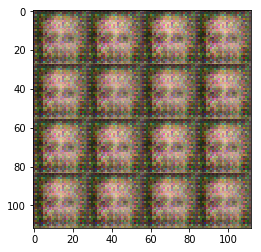

Epoch 1/1...Batch 110 Discriminator Loss: 0.6465... Generator Loss: 2.0265
Epoch 1/1...Batch 120 Discriminator Loss: 0.9747... Generator Loss: 1.0263
Epoch 1/1...Batch 130 Discriminator Loss: 0.8124... Generator Loss: 1.2338
Epoch 1/1...Batch 140 Discriminator Loss: 0.4942... Generator Loss: 2.5869
Epoch 1/1...Batch 150 Discriminator Loss: 0.5637... Generator Loss: 2.2209
Epoch 1/1...Batch 160 Discriminator Loss: 0.6315... Generator Loss: 1.9958
Epoch 1/1...Batch 170 Discriminator Loss: 0.5867... Generator Loss: 2.2152
Epoch 1/1...Batch 180 Discriminator Loss: 0.5177... Generator Loss: 2.4003
Epoch 1/1...Batch 190 Discriminator Loss: 0.6380... Generator Loss: 2.0468
Epoch 1/1...Batch 200 Discriminator Loss: 0.6881... Generator Loss: 1.6405


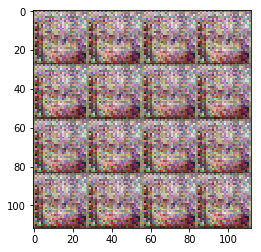

Epoch 1/1...Batch 210 Discriminator Loss: 0.5073... Generator Loss: 2.7609
Epoch 1/1...Batch 220 Discriminator Loss: 0.5553... Generator Loss: 3.5560
Epoch 1/1...Batch 230 Discriminator Loss: 0.7056... Generator Loss: 1.5586
Epoch 1/1...Batch 240 Discriminator Loss: 0.7769... Generator Loss: 1.6663
Epoch 1/1...Batch 250 Discriminator Loss: 0.5202... Generator Loss: 3.0894
Epoch 1/1...Batch 260 Discriminator Loss: 0.7501... Generator Loss: 1.6854
Epoch 1/1...Batch 270 Discriminator Loss: 0.5247... Generator Loss: 2.3523
Epoch 1/1...Batch 280 Discriminator Loss: 0.4859... Generator Loss: 2.2365
Epoch 1/1...Batch 290 Discriminator Loss: 0.4417... Generator Loss: 3.2224
Epoch 1/1...Batch 300 Discriminator Loss: 0.5712... Generator Loss: 2.2296


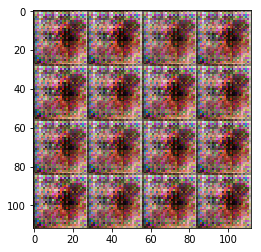

Epoch 1/1...Batch 310 Discriminator Loss: 0.5426... Generator Loss: 2.4738
Epoch 1/1...Batch 320 Discriminator Loss: 0.5354... Generator Loss: 1.9649
Epoch 1/1...Batch 330 Discriminator Loss: 0.6647... Generator Loss: 1.6114
Epoch 1/1...Batch 340 Discriminator Loss: 0.4488... Generator Loss: 2.8715
Epoch 1/1...Batch 350 Discriminator Loss: 0.5309... Generator Loss: 2.4885
Epoch 1/1...Batch 360 Discriminator Loss: 0.6580... Generator Loss: 1.8018
Epoch 1/1...Batch 370 Discriminator Loss: 0.8862... Generator Loss: 1.3094
Epoch 1/1...Batch 380 Discriminator Loss: 0.8049... Generator Loss: 1.4356
Epoch 1/1...Batch 390 Discriminator Loss: 1.2538... Generator Loss: 2.5020
Epoch 1/1...Batch 400 Discriminator Loss: 0.8819... Generator Loss: 1.1038


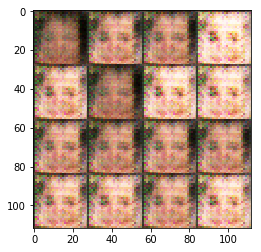

Epoch 1/1...Batch 410 Discriminator Loss: 0.8454... Generator Loss: 1.3996
Epoch 1/1...Batch 420 Discriminator Loss: 0.8950... Generator Loss: 1.7135
Epoch 1/1...Batch 430 Discriminator Loss: 1.3379... Generator Loss: 0.6058
Epoch 1/1...Batch 440 Discriminator Loss: 1.0616... Generator Loss: 0.9183
Epoch 1/1...Batch 450 Discriminator Loss: 1.2052... Generator Loss: 0.6873
Epoch 1/1...Batch 460 Discriminator Loss: 1.1225... Generator Loss: 1.0894
Epoch 1/1...Batch 470 Discriminator Loss: 1.4744... Generator Loss: 0.7203
Epoch 1/1...Batch 480 Discriminator Loss: 1.1010... Generator Loss: 1.2426
Epoch 1/1...Batch 490 Discriminator Loss: 1.4010... Generator Loss: 0.6955
Epoch 1/1...Batch 500 Discriminator Loss: 1.0627... Generator Loss: 1.0947


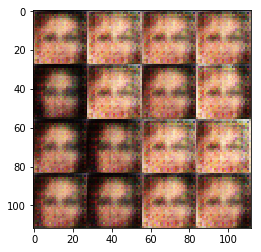

Epoch 1/1...Batch 510 Discriminator Loss: 0.8863... Generator Loss: 1.1443
Epoch 1/1...Batch 520 Discriminator Loss: 1.0175... Generator Loss: 1.0292
Epoch 1/1...Batch 530 Discriminator Loss: 1.0423... Generator Loss: 0.9310
Epoch 1/1...Batch 540 Discriminator Loss: 1.1012... Generator Loss: 1.1953
Epoch 1/1...Batch 550 Discriminator Loss: 0.9107... Generator Loss: 1.1101
Epoch 1/1...Batch 560 Discriminator Loss: 1.8716... Generator Loss: 0.4098
Epoch 1/1...Batch 570 Discriminator Loss: 1.1845... Generator Loss: 0.9578
Epoch 1/1...Batch 580 Discriminator Loss: 1.2116... Generator Loss: 0.8758
Epoch 1/1...Batch 590 Discriminator Loss: 0.8738... Generator Loss: 1.1377
Epoch 1/1...Batch 600 Discriminator Loss: 1.1181... Generator Loss: 2.0624


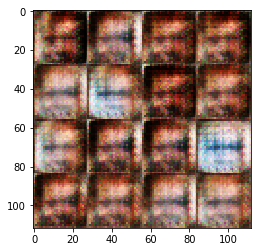

Epoch 1/1...Batch 610 Discriminator Loss: 0.9459... Generator Loss: 1.2438
Epoch 1/1...Batch 620 Discriminator Loss: 1.3977... Generator Loss: 1.5472
Epoch 1/1...Batch 630 Discriminator Loss: 0.8822... Generator Loss: 1.2311
Epoch 1/1...Batch 640 Discriminator Loss: 1.3711... Generator Loss: 2.2771
Epoch 1/1...Batch 650 Discriminator Loss: 0.8357... Generator Loss: 1.3616
Epoch 1/1...Batch 660 Discriminator Loss: 1.0864... Generator Loss: 1.2632
Epoch 1/1...Batch 670 Discriminator Loss: 0.9852... Generator Loss: 1.4369
Epoch 1/1...Batch 680 Discriminator Loss: 1.2183... Generator Loss: 0.6780
Epoch 1/1...Batch 690 Discriminator Loss: 1.1869... Generator Loss: 1.0534
Epoch 1/1...Batch 700 Discriminator Loss: 1.2692... Generator Loss: 0.8156


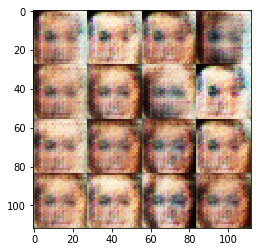

Epoch 1/1...Batch 710 Discriminator Loss: 1.1300... Generator Loss: 1.0684
Epoch 1/1...Batch 720 Discriminator Loss: 1.2005... Generator Loss: 0.9138
Epoch 1/1...Batch 730 Discriminator Loss: 1.5178... Generator Loss: 0.7050
Epoch 1/1...Batch 740 Discriminator Loss: 1.1411... Generator Loss: 0.9847
Epoch 1/1...Batch 750 Discriminator Loss: 1.2298... Generator Loss: 1.0617
Epoch 1/1...Batch 760 Discriminator Loss: 1.2339... Generator Loss: 1.1469
Epoch 1/1...Batch 770 Discriminator Loss: 1.1138... Generator Loss: 1.0537
Epoch 1/1...Batch 780 Discriminator Loss: 1.5639... Generator Loss: 1.0885
Epoch 1/1...Batch 790 Discriminator Loss: 1.2024... Generator Loss: 1.1962
Epoch 1/1...Batch 800 Discriminator Loss: 1.3158... Generator Loss: 0.8513


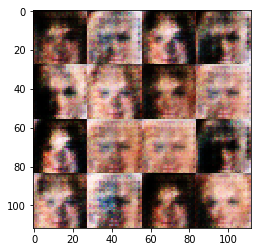

Epoch 1/1...Batch 810 Discriminator Loss: 1.3003... Generator Loss: 0.6610
Epoch 1/1...Batch 820 Discriminator Loss: 0.9098... Generator Loss: 1.5290
Epoch 1/1...Batch 830 Discriminator Loss: 1.5685... Generator Loss: 1.3502
Epoch 1/1...Batch 840 Discriminator Loss: 1.1588... Generator Loss: 0.8847
Epoch 1/1...Batch 850 Discriminator Loss: 1.0501... Generator Loss: 1.5509
Epoch 1/1...Batch 860 Discriminator Loss: 1.2548... Generator Loss: 0.9357
Epoch 1/1...Batch 870 Discriminator Loss: 1.3117... Generator Loss: 0.7194
Epoch 1/1...Batch 880 Discriminator Loss: 1.2021... Generator Loss: 0.7530
Epoch 1/1...Batch 890 Discriminator Loss: 1.2744... Generator Loss: 0.6981
Epoch 1/1...Batch 900 Discriminator Loss: 1.0674... Generator Loss: 1.0782


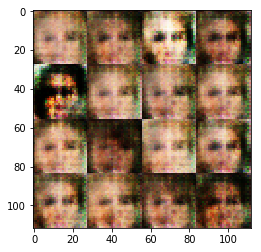

Epoch 1/1...Batch 910 Discriminator Loss: 1.4153... Generator Loss: 0.6491
Epoch 1/1...Batch 920 Discriminator Loss: 1.1290... Generator Loss: 1.1145
Epoch 1/1...Batch 930 Discriminator Loss: 1.5622... Generator Loss: 0.4211
Epoch 1/1...Batch 940 Discriminator Loss: 1.7269... Generator Loss: 0.5041
Epoch 1/1...Batch 950 Discriminator Loss: 1.0579... Generator Loss: 1.3317
Epoch 1/1...Batch 960 Discriminator Loss: 1.3867... Generator Loss: 0.8016
Epoch 1/1...Batch 970 Discriminator Loss: 1.2777... Generator Loss: 0.9561
Epoch 1/1...Batch 980 Discriminator Loss: 1.2671... Generator Loss: 0.8486
Epoch 1/1...Batch 990 Discriminator Loss: 1.5664... Generator Loss: 0.4868
Epoch 1/1...Batch 1000 Discriminator Loss: 1.3159... Generator Loss: 0.6946


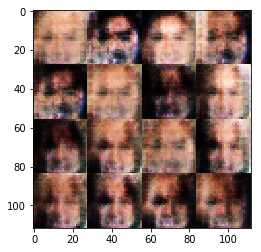

Epoch 1/1...Batch 1010 Discriminator Loss: 1.3618... Generator Loss: 0.6754
Epoch 1/1...Batch 1020 Discriminator Loss: 1.1624... Generator Loss: 0.9557
Epoch 1/1...Batch 1030 Discriminator Loss: 1.1908... Generator Loss: 0.7959
Epoch 1/1...Batch 1040 Discriminator Loss: 1.2508... Generator Loss: 0.9645
Epoch 1/1...Batch 1050 Discriminator Loss: 1.3319... Generator Loss: 1.1968
Epoch 1/1...Batch 1060 Discriminator Loss: 1.2574... Generator Loss: 1.0671
Epoch 1/1...Batch 1070 Discriminator Loss: 1.3205... Generator Loss: 0.8836
Epoch 1/1...Batch 1080 Discriminator Loss: 1.4172... Generator Loss: 1.1069
Epoch 1/1...Batch 1090 Discriminator Loss: 1.4295... Generator Loss: 0.6478
Epoch 1/1...Batch 1100 Discriminator Loss: 1.1675... Generator Loss: 1.2405


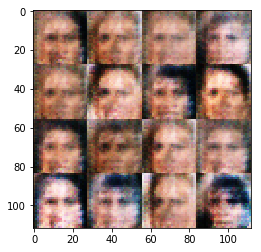

Epoch 1/1...Batch 1110 Discriminator Loss: 1.3213... Generator Loss: 0.6344
Epoch 1/1...Batch 1120 Discriminator Loss: 1.2957... Generator Loss: 0.7998
Epoch 1/1...Batch 1130 Discriminator Loss: 1.2701... Generator Loss: 0.8988
Epoch 1/1...Batch 1140 Discriminator Loss: 1.2543... Generator Loss: 0.9570
Epoch 1/1...Batch 1150 Discriminator Loss: 1.2671... Generator Loss: 1.5209
Epoch 1/1...Batch 1160 Discriminator Loss: 1.4465... Generator Loss: 1.3272
Epoch 1/1...Batch 1170 Discriminator Loss: 1.4923... Generator Loss: 0.9895
Epoch 1/1...Batch 1180 Discriminator Loss: 1.1568... Generator Loss: 1.1868
Epoch 1/1...Batch 1190 Discriminator Loss: 1.3737... Generator Loss: 0.6520
Epoch 1/1...Batch 1200 Discriminator Loss: 1.3505... Generator Loss: 0.6158


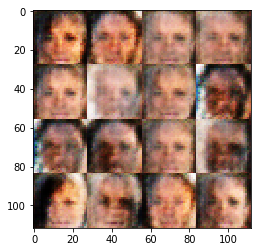

Epoch 1/1...Batch 1210 Discriminator Loss: 1.3433... Generator Loss: 0.8711
Epoch 1/1...Batch 1220 Discriminator Loss: 1.4129... Generator Loss: 0.5717
Epoch 1/1...Batch 1230 Discriminator Loss: 1.3695... Generator Loss: 0.8943
Epoch 1/1...Batch 1240 Discriminator Loss: 1.0797... Generator Loss: 1.0264
Epoch 1/1...Batch 1250 Discriminator Loss: 1.3031... Generator Loss: 0.6934
Epoch 1/1...Batch 1260 Discriminator Loss: 1.2311... Generator Loss: 0.8771
Epoch 1/1...Batch 1270 Discriminator Loss: 1.2232... Generator Loss: 1.1655
Epoch 1/1...Batch 1280 Discriminator Loss: 1.2146... Generator Loss: 0.9779
Epoch 1/1...Batch 1290 Discriminator Loss: 1.3002... Generator Loss: 0.8451
Epoch 1/1...Batch 1300 Discriminator Loss: 1.2748... Generator Loss: 0.8098


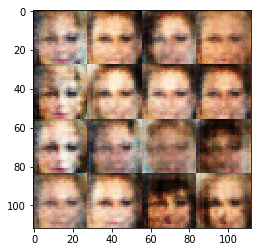

Epoch 1/1...Batch 1310 Discriminator Loss: 1.2775... Generator Loss: 0.6624
Epoch 1/1...Batch 1320 Discriminator Loss: 1.0995... Generator Loss: 1.0275
Epoch 1/1...Batch 1330 Discriminator Loss: 1.2235... Generator Loss: 1.2783
Epoch 1/1...Batch 1340 Discriminator Loss: 1.1112... Generator Loss: 1.3364
Epoch 1/1...Batch 1350 Discriminator Loss: 1.4451... Generator Loss: 0.6654
Epoch 1/1...Batch 1360 Discriminator Loss: 1.3295... Generator Loss: 1.0634
Epoch 1/1...Batch 1370 Discriminator Loss: 1.3723... Generator Loss: 0.7385
Epoch 1/1...Batch 1380 Discriminator Loss: 1.0808... Generator Loss: 1.0952
Epoch 1/1...Batch 1390 Discriminator Loss: 1.3237... Generator Loss: 0.7300
Epoch 1/1...Batch 1400 Discriminator Loss: 1.2327... Generator Loss: 0.7465


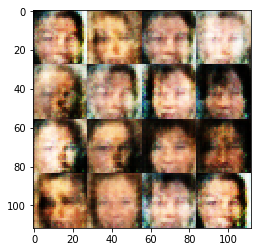

Epoch 1/1...Batch 1410 Discriminator Loss: 1.3370... Generator Loss: 0.8333
Epoch 1/1...Batch 1420 Discriminator Loss: 1.3850... Generator Loss: 0.8293
Epoch 1/1...Batch 1430 Discriminator Loss: 1.1585... Generator Loss: 0.9765
Epoch 1/1...Batch 1440 Discriminator Loss: 1.2437... Generator Loss: 0.8585
Epoch 1/1...Batch 1450 Discriminator Loss: 1.4258... Generator Loss: 0.5329
Epoch 1/1...Batch 1460 Discriminator Loss: 1.1926... Generator Loss: 1.0883
Epoch 1/1...Batch 1470 Discriminator Loss: 1.3857... Generator Loss: 0.6400
Epoch 1/1...Batch 1480 Discriminator Loss: 1.4031... Generator Loss: 0.7220
Epoch 1/1...Batch 1490 Discriminator Loss: 1.3890... Generator Loss: 1.0189
Epoch 1/1...Batch 1500 Discriminator Loss: 1.3919... Generator Loss: 1.0238


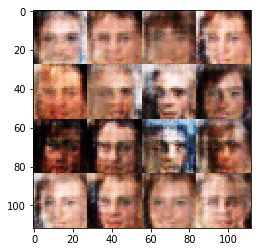

Epoch 1/1...Batch 1510 Discriminator Loss: 1.3592... Generator Loss: 0.9955
Epoch 1/1...Batch 1520 Discriminator Loss: 1.3376... Generator Loss: 1.3426
Epoch 1/1...Batch 1530 Discriminator Loss: 1.2636... Generator Loss: 0.6692
Epoch 1/1...Batch 1540 Discriminator Loss: 1.3475... Generator Loss: 0.8969
Epoch 1/1...Batch 1550 Discriminator Loss: 1.4673... Generator Loss: 0.5342
Epoch 1/1...Batch 1560 Discriminator Loss: 1.2133... Generator Loss: 0.8617
Epoch 1/1...Batch 1570 Discriminator Loss: 1.4349... Generator Loss: 1.0774
Epoch 1/1...Batch 1580 Discriminator Loss: 1.2456... Generator Loss: 0.9778
Epoch 1/1...Batch 1590 Discriminator Loss: 1.1717... Generator Loss: 0.9347
Epoch 1/1...Batch 1600 Discriminator Loss: 1.3666... Generator Loss: 0.8607


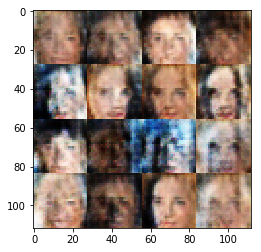

Epoch 1/1...Batch 1610 Discriminator Loss: 1.3262... Generator Loss: 0.6552
Epoch 1/1...Batch 1620 Discriminator Loss: 1.3947... Generator Loss: 0.7288
Epoch 1/1...Batch 1630 Discriminator Loss: 1.2154... Generator Loss: 0.9263
Epoch 1/1...Batch 1640 Discriminator Loss: 1.3615... Generator Loss: 0.7437
Epoch 1/1...Batch 1650 Discriminator Loss: 1.2101... Generator Loss: 1.1705
Epoch 1/1...Batch 1660 Discriminator Loss: 1.3116... Generator Loss: 0.8335
Epoch 1/1...Batch 1670 Discriminator Loss: 1.4398... Generator Loss: 1.0060
Epoch 1/1...Batch 1680 Discriminator Loss: 1.2249... Generator Loss: 0.8449
Epoch 1/1...Batch 1690 Discriminator Loss: 1.2850... Generator Loss: 0.9569
Epoch 1/1...Batch 1700 Discriminator Loss: 1.4058... Generator Loss: 0.8039


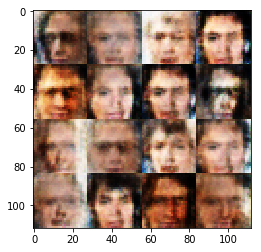

Epoch 1/1...Batch 1710 Discriminator Loss: 1.2048... Generator Loss: 0.9777
Epoch 1/1...Batch 1720 Discriminator Loss: 1.3058... Generator Loss: 0.7895
Epoch 1/1...Batch 1730 Discriminator Loss: 1.3187... Generator Loss: 0.7836
Epoch 1/1...Batch 1740 Discriminator Loss: 1.3350... Generator Loss: 0.9082
Epoch 1/1...Batch 1750 Discriminator Loss: 1.3254... Generator Loss: 0.8936
Epoch 1/1...Batch 1760 Discriminator Loss: 1.2972... Generator Loss: 0.9063
Epoch 1/1...Batch 1770 Discriminator Loss: 1.2093... Generator Loss: 0.8343
Epoch 1/1...Batch 1780 Discriminator Loss: 1.3060... Generator Loss: 1.0411
Epoch 1/1...Batch 1790 Discriminator Loss: 1.3239... Generator Loss: 1.2533
Epoch 1/1...Batch 1800 Discriminator Loss: 1.2514... Generator Loss: 0.8292


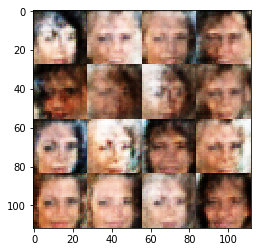

Epoch 1/1...Batch 1810 Discriminator Loss: 1.4591... Generator Loss: 1.2917
Epoch 1/1...Batch 1820 Discriminator Loss: 1.4288... Generator Loss: 0.6999
Epoch 1/1...Batch 1830 Discriminator Loss: 1.4166... Generator Loss: 0.7398
Epoch 1/1...Batch 1840 Discriminator Loss: 1.3116... Generator Loss: 0.7604
Epoch 1/1...Batch 1850 Discriminator Loss: 1.2152... Generator Loss: 0.9190
Epoch 1/1...Batch 1860 Discriminator Loss: 1.3853... Generator Loss: 0.7948
Epoch 1/1...Batch 1870 Discriminator Loss: 1.1330... Generator Loss: 0.8558
Epoch 1/1...Batch 1880 Discriminator Loss: 1.3669... Generator Loss: 0.6925
Epoch 1/1...Batch 1890 Discriminator Loss: 1.3038... Generator Loss: 0.7290
Epoch 1/1...Batch 1900 Discriminator Loss: 1.3592... Generator Loss: 0.8397


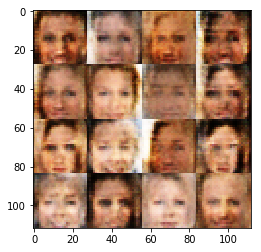

Epoch 1/1...Batch 1910 Discriminator Loss: 1.3488... Generator Loss: 0.9168
Epoch 1/1...Batch 1920 Discriminator Loss: 1.2568... Generator Loss: 0.7878
Epoch 1/1...Batch 1930 Discriminator Loss: 1.3709... Generator Loss: 0.7498
Epoch 1/1...Batch 1940 Discriminator Loss: 1.3155... Generator Loss: 0.8489
Epoch 1/1...Batch 1950 Discriminator Loss: 1.4656... Generator Loss: 0.5362
Epoch 1/1...Batch 1960 Discriminator Loss: 1.3374... Generator Loss: 0.7031
Epoch 1/1...Batch 1970 Discriminator Loss: 1.2040... Generator Loss: 0.9092
Epoch 1/1...Batch 1980 Discriminator Loss: 1.3835... Generator Loss: 0.6315
Epoch 1/1...Batch 1990 Discriminator Loss: 1.3377... Generator Loss: 1.0860
Epoch 1/1...Batch 2000 Discriminator Loss: 1.4027... Generator Loss: 0.7295


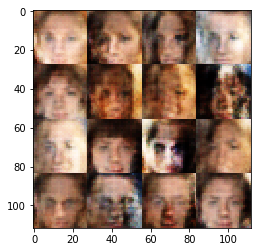

Epoch 1/1...Batch 2010 Discriminator Loss: 1.3008... Generator Loss: 0.8235
Epoch 1/1...Batch 2020 Discriminator Loss: 1.2929... Generator Loss: 0.9282
Epoch 1/1...Batch 2030 Discriminator Loss: 1.2984... Generator Loss: 0.7747
Epoch 1/1...Batch 2040 Discriminator Loss: 1.3170... Generator Loss: 1.0432
Epoch 1/1...Batch 2050 Discriminator Loss: 1.3390... Generator Loss: 0.8901
Epoch 1/1...Batch 2060 Discriminator Loss: 1.2936... Generator Loss: 1.0344
Epoch 1/1...Batch 2070 Discriminator Loss: 1.4144... Generator Loss: 0.8248
Epoch 1/1...Batch 2080 Discriminator Loss: 1.2467... Generator Loss: 1.1149
Epoch 1/1...Batch 2090 Discriminator Loss: 1.2652... Generator Loss: 0.8710
Epoch 1/1...Batch 2100 Discriminator Loss: 1.2991... Generator Loss: 0.9660


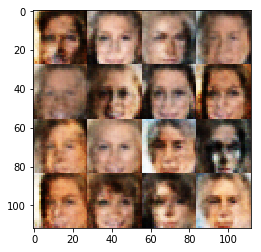

Epoch 1/1...Batch 2110 Discriminator Loss: 1.4023... Generator Loss: 0.5206
Epoch 1/1...Batch 2120 Discriminator Loss: 1.2870... Generator Loss: 0.8740
Epoch 1/1...Batch 2130 Discriminator Loss: 1.3494... Generator Loss: 0.6829
Epoch 1/1...Batch 2140 Discriminator Loss: 1.3691... Generator Loss: 0.7303
Epoch 1/1...Batch 2150 Discriminator Loss: 1.2193... Generator Loss: 0.8607
Epoch 1/1...Batch 2160 Discriminator Loss: 1.2001... Generator Loss: 0.9206
Epoch 1/1...Batch 2170 Discriminator Loss: 1.2867... Generator Loss: 0.9891
Epoch 1/1...Batch 2180 Discriminator Loss: 1.2710... Generator Loss: 0.7300
Epoch 1/1...Batch 2190 Discriminator Loss: 1.3755... Generator Loss: 0.6594
Epoch 1/1...Batch 2200 Discriminator Loss: 1.3289... Generator Loss: 0.6919


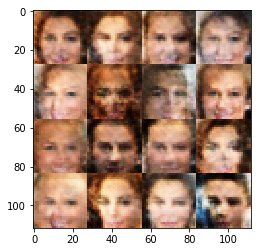

Epoch 1/1...Batch 2210 Discriminator Loss: 1.2095... Generator Loss: 0.9773
Epoch 1/1...Batch 2220 Discriminator Loss: 1.4010... Generator Loss: 0.6230
Epoch 1/1...Batch 2230 Discriminator Loss: 1.3412... Generator Loss: 0.7742
Epoch 1/1...Batch 2240 Discriminator Loss: 1.1571... Generator Loss: 0.9415
Epoch 1/1...Batch 2250 Discriminator Loss: 1.1661... Generator Loss: 0.9636
Epoch 1/1...Batch 2260 Discriminator Loss: 1.2437... Generator Loss: 0.9038
Epoch 1/1...Batch 2270 Discriminator Loss: 1.2882... Generator Loss: 0.8710
Epoch 1/1...Batch 2280 Discriminator Loss: 1.1470... Generator Loss: 1.0963
Epoch 1/1...Batch 2290 Discriminator Loss: 1.3277... Generator Loss: 0.9347
Epoch 1/1...Batch 2300 Discriminator Loss: 1.2554... Generator Loss: 1.0448


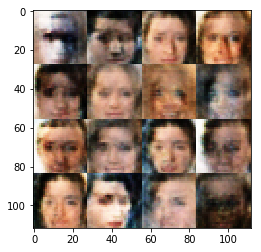

Epoch 1/1...Batch 2310 Discriminator Loss: 1.2730... Generator Loss: 0.8096
Epoch 1/1...Batch 2320 Discriminator Loss: 1.3609... Generator Loss: 0.8315
Epoch 1/1...Batch 2330 Discriminator Loss: 1.2916... Generator Loss: 0.6883
Epoch 1/1...Batch 2340 Discriminator Loss: 1.2741... Generator Loss: 0.7191
Epoch 1/1...Batch 2350 Discriminator Loss: 1.3370... Generator Loss: 0.8908
Epoch 1/1...Batch 2360 Discriminator Loss: 1.1960... Generator Loss: 1.0805
Epoch 1/1...Batch 2370 Discriminator Loss: 1.3266... Generator Loss: 0.7997
Epoch 1/1...Batch 2380 Discriminator Loss: 1.2056... Generator Loss: 0.8869
Epoch 1/1...Batch 2390 Discriminator Loss: 1.3066... Generator Loss: 0.7126
Epoch 1/1...Batch 2400 Discriminator Loss: 1.3121... Generator Loss: 0.6412


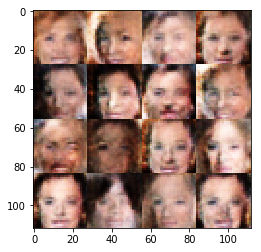

Epoch 1/1...Batch 2410 Discriminator Loss: 1.2596... Generator Loss: 0.9760
Epoch 1/1...Batch 2420 Discriminator Loss: 1.4738... Generator Loss: 0.6410
Epoch 1/1...Batch 2430 Discriminator Loss: 1.3651... Generator Loss: 0.5597
Epoch 1/1...Batch 2440 Discriminator Loss: 1.1199... Generator Loss: 0.9815
Epoch 1/1...Batch 2450 Discriminator Loss: 1.4012... Generator Loss: 0.5860
Epoch 1/1...Batch 2460 Discriminator Loss: 1.2420... Generator Loss: 0.8981
Epoch 1/1...Batch 2470 Discriminator Loss: 1.3433... Generator Loss: 0.6327
Epoch 1/1...Batch 2480 Discriminator Loss: 1.2390... Generator Loss: 0.7516
Epoch 1/1...Batch 2490 Discriminator Loss: 1.2946... Generator Loss: 0.6253
Epoch 1/1...Batch 2500 Discriminator Loss: 1.1917... Generator Loss: 0.9022


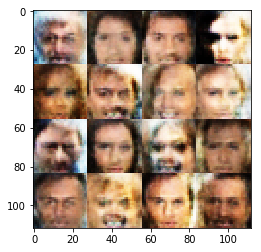

Epoch 1/1...Batch 2510 Discriminator Loss: 1.3442... Generator Loss: 0.6955
Epoch 1/1...Batch 2520 Discriminator Loss: 1.4014... Generator Loss: 0.5927
Epoch 1/1...Batch 2530 Discriminator Loss: 1.4119... Generator Loss: 0.5982
Epoch 1/1...Batch 2540 Discriminator Loss: 1.3660... Generator Loss: 0.5952
Epoch 1/1...Batch 2550 Discriminator Loss: 1.2720... Generator Loss: 0.8013
Epoch 1/1...Batch 2560 Discriminator Loss: 1.1982... Generator Loss: 0.8802
Epoch 1/1...Batch 2570 Discriminator Loss: 1.2849... Generator Loss: 0.6474
Epoch 1/1...Batch 2580 Discriminator Loss: 1.2910... Generator Loss: 0.7187
Epoch 1/1...Batch 2590 Discriminator Loss: 1.2799... Generator Loss: 1.1532
Epoch 1/1...Batch 2600 Discriminator Loss: 1.3883... Generator Loss: 0.6029


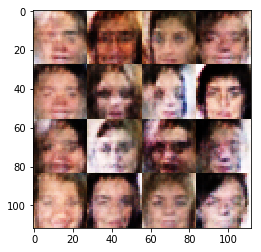

Epoch 1/1...Batch 2610 Discriminator Loss: 1.4299... Generator Loss: 0.6112
Epoch 1/1...Batch 2620 Discriminator Loss: 1.3450... Generator Loss: 0.8966
Epoch 1/1...Batch 2630 Discriminator Loss: 1.3238... Generator Loss: 0.7430
Epoch 1/1...Batch 2640 Discriminator Loss: 1.1225... Generator Loss: 0.8703
Epoch 1/1...Batch 2650 Discriminator Loss: 1.4508... Generator Loss: 0.5860
Epoch 1/1...Batch 2660 Discriminator Loss: 1.3037... Generator Loss: 0.7824
Epoch 1/1...Batch 2670 Discriminator Loss: 1.3378... Generator Loss: 0.6661
Epoch 1/1...Batch 2680 Discriminator Loss: 1.2758... Generator Loss: 0.9833
Epoch 1/1...Batch 2690 Discriminator Loss: 1.3576... Generator Loss: 0.6910
Epoch 1/1...Batch 2700 Discriminator Loss: 1.3047... Generator Loss: 0.7197


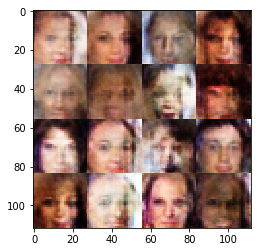

Epoch 1/1...Batch 2710 Discriminator Loss: 1.2503... Generator Loss: 0.8188
Epoch 1/1...Batch 2720 Discriminator Loss: 1.2192... Generator Loss: 0.9983
Epoch 1/1...Batch 2730 Discriminator Loss: 1.3521... Generator Loss: 0.5899
Epoch 1/1...Batch 2740 Discriminator Loss: 1.2392... Generator Loss: 0.9388
Epoch 1/1...Batch 2750 Discriminator Loss: 1.1500... Generator Loss: 1.0337
Epoch 1/1...Batch 2760 Discriminator Loss: 1.2644... Generator Loss: 0.8664
Epoch 1/1...Batch 2770 Discriminator Loss: 1.4642... Generator Loss: 0.5065
Epoch 1/1...Batch 2780 Discriminator Loss: 1.1576... Generator Loss: 0.9963
Epoch 1/1...Batch 2790 Discriminator Loss: 1.2441... Generator Loss: 0.7272
Epoch 1/1...Batch 2800 Discriminator Loss: 1.2852... Generator Loss: 0.6655


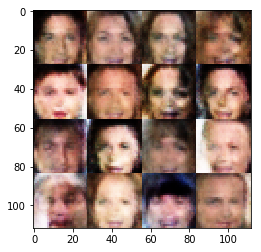

Epoch 1/1...Batch 2810 Discriminator Loss: 1.3852... Generator Loss: 0.8217
Epoch 1/1...Batch 2820 Discriminator Loss: 1.1571... Generator Loss: 0.9973
Epoch 1/1...Batch 2830 Discriminator Loss: 1.4568... Generator Loss: 0.9848
Epoch 1/1...Batch 2840 Discriminator Loss: 1.3579... Generator Loss: 0.7550
Epoch 1/1...Batch 2850 Discriminator Loss: 1.2817... Generator Loss: 0.6742
Epoch 1/1...Batch 2860 Discriminator Loss: 1.2286... Generator Loss: 0.7411
Epoch 1/1...Batch 2870 Discriminator Loss: 1.1840... Generator Loss: 0.9226
Epoch 1/1...Batch 2880 Discriminator Loss: 1.4765... Generator Loss: 0.4831
Epoch 1/1...Batch 2890 Discriminator Loss: 1.0920... Generator Loss: 1.0126
Epoch 1/1...Batch 2900 Discriminator Loss: 1.1826... Generator Loss: 0.8872


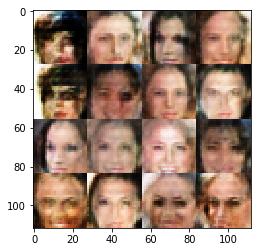

Epoch 1/1...Batch 2910 Discriminator Loss: 1.3172... Generator Loss: 0.6292
Epoch 1/1...Batch 2920 Discriminator Loss: 1.3516... Generator Loss: 1.3192
Epoch 1/1...Batch 2930 Discriminator Loss: 1.3050... Generator Loss: 1.5018
Epoch 1/1...Batch 2940 Discriminator Loss: 1.2832... Generator Loss: 0.7595
Epoch 1/1...Batch 2950 Discriminator Loss: 1.2148... Generator Loss: 0.9515
Epoch 1/1...Batch 2960 Discriminator Loss: 1.2682... Generator Loss: 1.0362
Epoch 1/1...Batch 2970 Discriminator Loss: 1.3623... Generator Loss: 0.5782
Epoch 1/1...Batch 2980 Discriminator Loss: 1.2711... Generator Loss: 0.7851
Epoch 1/1...Batch 2990 Discriminator Loss: 1.2880... Generator Loss: 1.3698
Epoch 1/1...Batch 3000 Discriminator Loss: 1.3262... Generator Loss: 0.8640


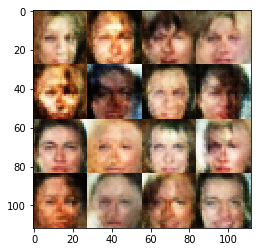

Epoch 1/1...Batch 3010 Discriminator Loss: 1.3795... Generator Loss: 0.7046
Epoch 1/1...Batch 3020 Discriminator Loss: 1.2727... Generator Loss: 0.7864
Epoch 1/1...Batch 3030 Discriminator Loss: 1.1176... Generator Loss: 0.8786
Epoch 1/1...Batch 3040 Discriminator Loss: 1.2134... Generator Loss: 0.9409
Epoch 1/1...Batch 3050 Discriminator Loss: 1.2567... Generator Loss: 0.6583
Epoch 1/1...Batch 3060 Discriminator Loss: 1.3343... Generator Loss: 0.5959
Epoch 1/1...Batch 3070 Discriminator Loss: 1.4751... Generator Loss: 0.7852
Epoch 1/1...Batch 3080 Discriminator Loss: 1.2677... Generator Loss: 0.7323
Epoch 1/1...Batch 3090 Discriminator Loss: 1.2178... Generator Loss: 0.9371
Epoch 1/1...Batch 3100 Discriminator Loss: 1.1208... Generator Loss: 0.8429


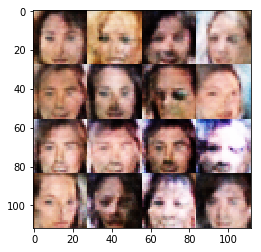

Epoch 1/1...Batch 3110 Discriminator Loss: 1.2656... Generator Loss: 0.8899
Epoch 1/1...Batch 3120 Discriminator Loss: 1.1494... Generator Loss: 1.0078
Epoch 1/1...Batch 3130 Discriminator Loss: 1.3292... Generator Loss: 0.7972
Epoch 1/1...Batch 3140 Discriminator Loss: 1.3280... Generator Loss: 0.7084
Epoch 1/1...Batch 3150 Discriminator Loss: 1.1539... Generator Loss: 0.7706
Epoch 1/1...Batch 3160 Discriminator Loss: 1.3424... Generator Loss: 0.6528
Epoch 1/1...Batch 3170 Discriminator Loss: 1.1462... Generator Loss: 1.1515
Epoch 1/1...Batch 3180 Discriminator Loss: 1.2977... Generator Loss: 0.6739
Epoch 1/1...Batch 3190 Discriminator Loss: 1.6533... Generator Loss: 0.3542
Epoch 1/1...Batch 3200 Discriminator Loss: 1.1009... Generator Loss: 1.1234


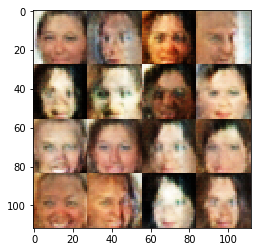

Epoch 1/1...Batch 3210 Discriminator Loss: 1.2214... Generator Loss: 0.8846
Epoch 1/1...Batch 3220 Discriminator Loss: 1.1206... Generator Loss: 1.0620
Epoch 1/1...Batch 3230 Discriminator Loss: 1.1404... Generator Loss: 0.9525
Epoch 1/1...Batch 3240 Discriminator Loss: 1.1891... Generator Loss: 0.9311
Epoch 1/1...Batch 3250 Discriminator Loss: 1.2912... Generator Loss: 0.7245
Epoch 1/1...Batch 3260 Discriminator Loss: 1.2841... Generator Loss: 0.8351
Epoch 1/1...Batch 3270 Discriminator Loss: 1.2566... Generator Loss: 0.6625
Epoch 1/1...Batch 3280 Discriminator Loss: 1.1938... Generator Loss: 0.7648
Epoch 1/1...Batch 3290 Discriminator Loss: 1.3878... Generator Loss: 0.7619
Epoch 1/1...Batch 3300 Discriminator Loss: 1.2166... Generator Loss: 0.8152


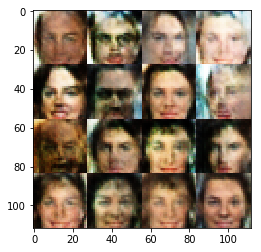

Epoch 1/1...Batch 3310 Discriminator Loss: 1.3699... Generator Loss: 0.6552
Epoch 1/1...Batch 3320 Discriminator Loss: 1.4224... Generator Loss: 0.4934
Epoch 1/1...Batch 3330 Discriminator Loss: 1.4986... Generator Loss: 0.4642
Epoch 1/1...Batch 3340 Discriminator Loss: 1.3086... Generator Loss: 0.6636
Epoch 1/1...Batch 3350 Discriminator Loss: 1.2992... Generator Loss: 1.0319
Epoch 1/1...Batch 3360 Discriminator Loss: 1.2238... Generator Loss: 1.0634
Epoch 1/1...Batch 3370 Discriminator Loss: 1.2242... Generator Loss: 0.7972
Epoch 1/1...Batch 3380 Discriminator Loss: 1.2472... Generator Loss: 0.7927
Epoch 1/1...Batch 3390 Discriminator Loss: 1.4106... Generator Loss: 0.6565
Epoch 1/1...Batch 3400 Discriminator Loss: 1.1652... Generator Loss: 1.0091


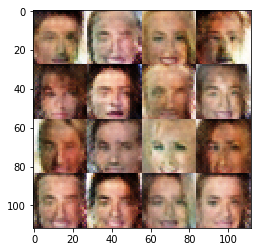

Epoch 1/1...Batch 3410 Discriminator Loss: 1.3122... Generator Loss: 0.7784
Epoch 1/1...Batch 3420 Discriminator Loss: 1.2865... Generator Loss: 0.7617
Epoch 1/1...Batch 3430 Discriminator Loss: 1.1950... Generator Loss: 0.9265
Epoch 1/1...Batch 3440 Discriminator Loss: 1.3036... Generator Loss: 0.7335
Epoch 1/1...Batch 3450 Discriminator Loss: 1.1206... Generator Loss: 0.9995
Epoch 1/1...Batch 3460 Discriminator Loss: 1.1303... Generator Loss: 0.9342
Epoch 1/1...Batch 3470 Discriminator Loss: 1.4375... Generator Loss: 0.5808
Epoch 1/1...Batch 3480 Discriminator Loss: 1.3714... Generator Loss: 1.1653
Epoch 1/1...Batch 3490 Discriminator Loss: 1.2358... Generator Loss: 0.8690
Epoch 1/1...Batch 3500 Discriminator Loss: 1.2788... Generator Loss: 0.9034


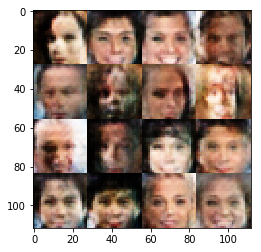

Epoch 1/1...Batch 3510 Discriminator Loss: 1.3232... Generator Loss: 0.6945
Epoch 1/1...Batch 3520 Discriminator Loss: 1.4202... Generator Loss: 0.6501
Epoch 1/1...Batch 3530 Discriminator Loss: 1.4478... Generator Loss: 0.5043
Epoch 1/1...Batch 3540 Discriminator Loss: 1.2002... Generator Loss: 0.7475
Epoch 1/1...Batch 3550 Discriminator Loss: 1.2019... Generator Loss: 1.2943
Epoch 1/1...Batch 3560 Discriminator Loss: 1.3976... Generator Loss: 0.5947
Epoch 1/1...Batch 3570 Discriminator Loss: 1.3035... Generator Loss: 0.7195
Epoch 1/1...Batch 3580 Discriminator Loss: 1.2952... Generator Loss: 0.9784
Epoch 1/1...Batch 3590 Discriminator Loss: 1.1473... Generator Loss: 1.0015
Epoch 1/1...Batch 3600 Discriminator Loss: 1.3988... Generator Loss: 0.5719


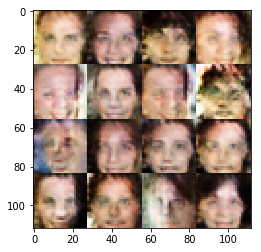

Epoch 1/1...Batch 3610 Discriminator Loss: 1.3030... Generator Loss: 0.6073
Epoch 1/1...Batch 3620 Discriminator Loss: 1.1998... Generator Loss: 0.6967
Epoch 1/1...Batch 3630 Discriminator Loss: 1.2928... Generator Loss: 0.7369
Epoch 1/1...Batch 3640 Discriminator Loss: 1.2057... Generator Loss: 1.1046
Epoch 1/1...Batch 3650 Discriminator Loss: 1.2241... Generator Loss: 1.4030
Epoch 1/1...Batch 3660 Discriminator Loss: 1.1880... Generator Loss: 0.9153
Epoch 1/1...Batch 3670 Discriminator Loss: 1.2151... Generator Loss: 0.9459
Epoch 1/1...Batch 3680 Discriminator Loss: 1.3018... Generator Loss: 0.7662
Epoch 1/1...Batch 3690 Discriminator Loss: 1.2541... Generator Loss: 0.9167
Epoch 1/1...Batch 3700 Discriminator Loss: 1.1466... Generator Loss: 0.8708


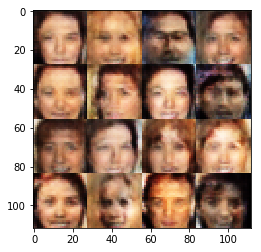

Epoch 1/1...Batch 3710 Discriminator Loss: 1.2158... Generator Loss: 0.7692
Epoch 1/1...Batch 3720 Discriminator Loss: 1.2358... Generator Loss: 1.1785
Epoch 1/1...Batch 3730 Discriminator Loss: 1.2102... Generator Loss: 1.0064
Epoch 1/1...Batch 3740 Discriminator Loss: 1.3723... Generator Loss: 0.8782
Epoch 1/1...Batch 3750 Discriminator Loss: 1.3500... Generator Loss: 0.7744
Epoch 1/1...Batch 3760 Discriminator Loss: 1.1769... Generator Loss: 0.7527
Epoch 1/1...Batch 3770 Discriminator Loss: 1.1149... Generator Loss: 0.7639
Epoch 1/1...Batch 3780 Discriminator Loss: 1.0766... Generator Loss: 0.9314
Epoch 1/1...Batch 3790 Discriminator Loss: 1.2455... Generator Loss: 0.9675
Epoch 1/1...Batch 3800 Discriminator Loss: 1.3854... Generator Loss: 0.6553


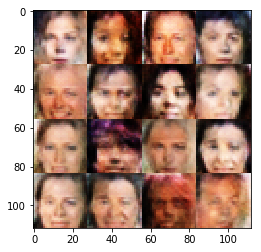

Epoch 1/1...Batch 3810 Discriminator Loss: 1.1882... Generator Loss: 1.3922
Epoch 1/1...Batch 3820 Discriminator Loss: 1.2511... Generator Loss: 0.6215
Epoch 1/1...Batch 3830 Discriminator Loss: 1.3850... Generator Loss: 0.6857
Epoch 1/1...Batch 3840 Discriminator Loss: 1.2622... Generator Loss: 0.7190
Epoch 1/1...Batch 3850 Discriminator Loss: 1.3938... Generator Loss: 0.8420
Epoch 1/1...Batch 3860 Discriminator Loss: 1.3901... Generator Loss: 0.6175
Epoch 1/1...Batch 3870 Discriminator Loss: 1.2107... Generator Loss: 0.8915
Epoch 1/1...Batch 3880 Discriminator Loss: 1.3256... Generator Loss: 0.9011
Epoch 1/1...Batch 3890 Discriminator Loss: 1.3867... Generator Loss: 0.5820
Epoch 1/1...Batch 3900 Discriminator Loss: 1.1333... Generator Loss: 0.9812


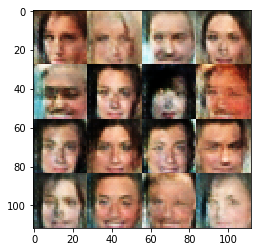

Epoch 1/1...Batch 3910 Discriminator Loss: 1.2775... Generator Loss: 1.0158
Epoch 1/1...Batch 3920 Discriminator Loss: 1.1502... Generator Loss: 1.0094
Epoch 1/1...Batch 3930 Discriminator Loss: 1.2574... Generator Loss: 0.8978
Epoch 1/1...Batch 3940 Discriminator Loss: 1.2825... Generator Loss: 0.7613
Epoch 1/1...Batch 3950 Discriminator Loss: 1.1234... Generator Loss: 1.0922
Epoch 1/1...Batch 3960 Discriminator Loss: 1.2615... Generator Loss: 0.6436
Epoch 1/1...Batch 3970 Discriminator Loss: 1.1580... Generator Loss: 0.9221
Epoch 1/1...Batch 3980 Discriminator Loss: 0.9907... Generator Loss: 1.6410
Epoch 1/1...Batch 3990 Discriminator Loss: 1.3672... Generator Loss: 0.6821
Epoch 1/1...Batch 4000 Discriminator Loss: 1.1166... Generator Loss: 1.0895


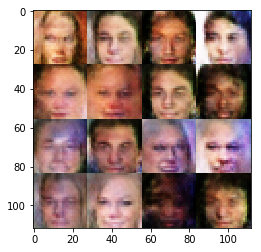

Epoch 1/1...Batch 4010 Discriminator Loss: 1.1746... Generator Loss: 0.8425
Epoch 1/1...Batch 4020 Discriminator Loss: 1.2760... Generator Loss: 0.8762
Epoch 1/1...Batch 4030 Discriminator Loss: 1.2738... Generator Loss: 1.1228
Epoch 1/1...Batch 4040 Discriminator Loss: 1.1352... Generator Loss: 0.8106
Epoch 1/1...Batch 4050 Discriminator Loss: 1.4007... Generator Loss: 0.6217
Epoch 1/1...Batch 4060 Discriminator Loss: 1.2352... Generator Loss: 0.7571
Epoch 1/1...Batch 4070 Discriminator Loss: 1.2811... Generator Loss: 0.6629
Epoch 1/1...Batch 4080 Discriminator Loss: 1.2411... Generator Loss: 0.8547
Epoch 1/1...Batch 4090 Discriminator Loss: 1.2236... Generator Loss: 0.8115
Epoch 1/1...Batch 4100 Discriminator Loss: 1.0833... Generator Loss: 1.0872


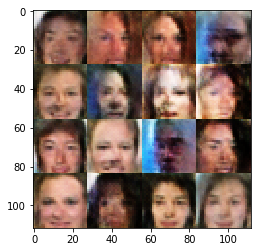

Epoch 1/1...Batch 4110 Discriminator Loss: 1.2866... Generator Loss: 0.7421
Epoch 1/1...Batch 4120 Discriminator Loss: 1.0900... Generator Loss: 0.9954
Epoch 1/1...Batch 4130 Discriminator Loss: 1.2634... Generator Loss: 1.3180
Epoch 1/1...Batch 4140 Discriminator Loss: 1.1780... Generator Loss: 0.9840
Epoch 1/1...Batch 4150 Discriminator Loss: 1.4406... Generator Loss: 0.4639
Epoch 1/1...Batch 4160 Discriminator Loss: 1.5143... Generator Loss: 0.4830
Epoch 1/1...Batch 4170 Discriminator Loss: 1.1574... Generator Loss: 0.8723
Epoch 1/1...Batch 4180 Discriminator Loss: 0.9976... Generator Loss: 1.1651
Epoch 1/1...Batch 4190 Discriminator Loss: 1.1291... Generator Loss: 1.6282
Epoch 1/1...Batch 4200 Discriminator Loss: 1.5798... Generator Loss: 0.4106


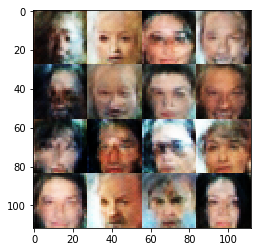

Epoch 1/1...Batch 4210 Discriminator Loss: 1.1927... Generator Loss: 1.2408
Epoch 1/1...Batch 4220 Discriminator Loss: 1.1779... Generator Loss: 0.7753
Epoch 1/1...Batch 4230 Discriminator Loss: 1.2190... Generator Loss: 1.0264
Epoch 1/1...Batch 4240 Discriminator Loss: 1.2681... Generator Loss: 0.6368
Epoch 1/1...Batch 4250 Discriminator Loss: 1.3485... Generator Loss: 0.6710
Epoch 1/1...Batch 4260 Discriminator Loss: 1.3697... Generator Loss: 1.0777
Epoch 1/1...Batch 4270 Discriminator Loss: 1.1891... Generator Loss: 0.8005
Epoch 1/1...Batch 4280 Discriminator Loss: 1.3061... Generator Loss: 0.6712
Epoch 1/1...Batch 4290 Discriminator Loss: 1.2627... Generator Loss: 1.2268
Epoch 1/1...Batch 4300 Discriminator Loss: 1.2416... Generator Loss: 0.8016


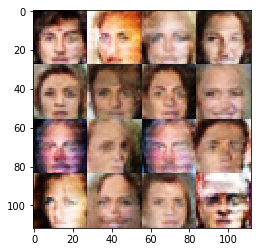

Epoch 1/1...Batch 4310 Discriminator Loss: 1.2946... Generator Loss: 0.7010
Epoch 1/1...Batch 4320 Discriminator Loss: 1.0619... Generator Loss: 1.1612
Epoch 1/1...Batch 4330 Discriminator Loss: 1.2606... Generator Loss: 0.7332
Epoch 1/1...Batch 4340 Discriminator Loss: 1.2146... Generator Loss: 0.7318
Epoch 1/1...Batch 4350 Discriminator Loss: 1.1992... Generator Loss: 0.6889
Epoch 1/1...Batch 4360 Discriminator Loss: 1.2668... Generator Loss: 0.8358
Epoch 1/1...Batch 4370 Discriminator Loss: 1.1872... Generator Loss: 0.8977
Epoch 1/1...Batch 4380 Discriminator Loss: 1.2119... Generator Loss: 0.8684
Epoch 1/1...Batch 4390 Discriminator Loss: 1.1657... Generator Loss: 0.8416
Epoch 1/1...Batch 4400 Discriminator Loss: 1.3029... Generator Loss: 0.6247


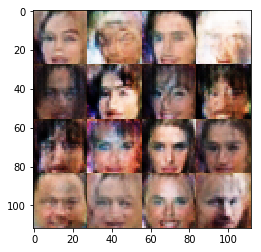

Epoch 1/1...Batch 4410 Discriminator Loss: 1.1283... Generator Loss: 0.9081
Epoch 1/1...Batch 4420 Discriminator Loss: 1.1622... Generator Loss: 1.0450
Epoch 1/1...Batch 4430 Discriminator Loss: 1.1958... Generator Loss: 0.9949
Epoch 1/1...Batch 4440 Discriminator Loss: 1.1528... Generator Loss: 0.7202
Epoch 1/1...Batch 4450 Discriminator Loss: 0.9507... Generator Loss: 1.4408
Epoch 1/1...Batch 4460 Discriminator Loss: 1.1033... Generator Loss: 0.9205
Epoch 1/1...Batch 4470 Discriminator Loss: 1.1653... Generator Loss: 1.0764
Epoch 1/1...Batch 4480 Discriminator Loss: 1.4006... Generator Loss: 0.4961
Epoch 1/1...Batch 4490 Discriminator Loss: 1.2460... Generator Loss: 0.8471
Epoch 1/1...Batch 4500 Discriminator Loss: 1.3169... Generator Loss: 0.5825


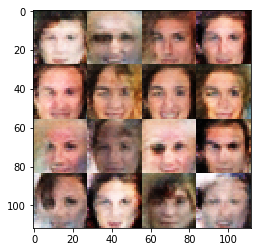

Epoch 1/1...Batch 4510 Discriminator Loss: 1.2386... Generator Loss: 1.0355
Epoch 1/1...Batch 4520 Discriminator Loss: 1.0846... Generator Loss: 0.9141
Epoch 1/1...Batch 4530 Discriminator Loss: 1.0403... Generator Loss: 0.9159
Epoch 1/1...Batch 4540 Discriminator Loss: 1.0253... Generator Loss: 1.0198
Epoch 1/1...Batch 4550 Discriminator Loss: 1.2220... Generator Loss: 1.0175
Epoch 1/1...Batch 4560 Discriminator Loss: 1.2681... Generator Loss: 0.7540
Epoch 1/1...Batch 4570 Discriminator Loss: 1.2667... Generator Loss: 0.6900
Epoch 1/1...Batch 4580 Discriminator Loss: 1.1083... Generator Loss: 0.9535
Epoch 1/1...Batch 4590 Discriminator Loss: 1.2570... Generator Loss: 0.6722
Epoch 1/1...Batch 4600 Discriminator Loss: 1.1672... Generator Loss: 0.9772


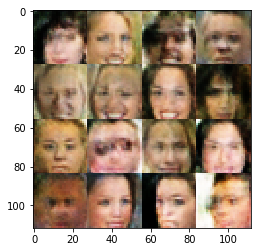

Epoch 1/1...Batch 4610 Discriminator Loss: 1.2942... Generator Loss: 0.6823
Epoch 1/1...Batch 4620 Discriminator Loss: 1.2443... Generator Loss: 0.8532
Epoch 1/1...Batch 4630 Discriminator Loss: 1.3687... Generator Loss: 0.6569
Epoch 1/1...Batch 4640 Discriminator Loss: 1.1359... Generator Loss: 0.8543
Epoch 1/1...Batch 4650 Discriminator Loss: 1.1622... Generator Loss: 0.7972
Epoch 1/1...Batch 4660 Discriminator Loss: 1.2601... Generator Loss: 0.7803
Epoch 1/1...Batch 4670 Discriminator Loss: 1.0620... Generator Loss: 1.2097
Epoch 1/1...Batch 4680 Discriminator Loss: 1.8782... Generator Loss: 0.2979
Epoch 1/1...Batch 4690 Discriminator Loss: 1.2792... Generator Loss: 0.6716
Epoch 1/1...Batch 4700 Discriminator Loss: 1.1507... Generator Loss: 1.1652


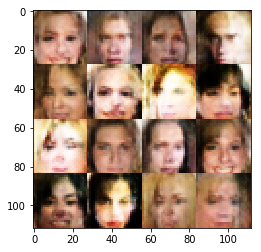

Epoch 1/1...Batch 4710 Discriminator Loss: 1.4488... Generator Loss: 0.5438
Epoch 1/1...Batch 4720 Discriminator Loss: 1.0782... Generator Loss: 1.1531
Epoch 1/1...Batch 4730 Discriminator Loss: 1.4501... Generator Loss: 0.9321
Epoch 1/1...Batch 4740 Discriminator Loss: 1.1835... Generator Loss: 0.8930
Epoch 1/1...Batch 4750 Discriminator Loss: 1.3083... Generator Loss: 0.6306
Epoch 1/1...Batch 4760 Discriminator Loss: 1.1020... Generator Loss: 0.8803
Epoch 1/1...Batch 4770 Discriminator Loss: 1.0135... Generator Loss: 1.0611
Epoch 1/1...Batch 4780 Discriminator Loss: 1.1696... Generator Loss: 0.9317
Epoch 1/1...Batch 4790 Discriminator Loss: 1.0618... Generator Loss: 1.0494
Epoch 1/1...Batch 4800 Discriminator Loss: 1.5890... Generator Loss: 0.3795


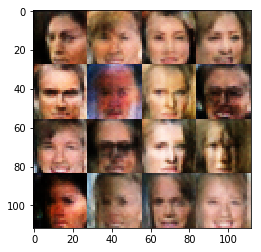

Epoch 1/1...Batch 4810 Discriminator Loss: 1.2418... Generator Loss: 0.8805
Epoch 1/1...Batch 4820 Discriminator Loss: 1.3822... Generator Loss: 0.6446
Epoch 1/1...Batch 4830 Discriminator Loss: 1.4530... Generator Loss: 0.5029
Epoch 1/1...Batch 4840 Discriminator Loss: 1.2135... Generator Loss: 0.8467
Epoch 1/1...Batch 4850 Discriminator Loss: 1.1091... Generator Loss: 0.9894
Epoch 1/1...Batch 4860 Discriminator Loss: 1.1792... Generator Loss: 0.8168
Epoch 1/1...Batch 4870 Discriminator Loss: 1.2778... Generator Loss: 1.1621
Epoch 1/1...Batch 4880 Discriminator Loss: 1.3514... Generator Loss: 0.6515
Epoch 1/1...Batch 4890 Discriminator Loss: 1.1825... Generator Loss: 0.7448
Epoch 1/1...Batch 4900 Discriminator Loss: 1.2872... Generator Loss: 0.9706


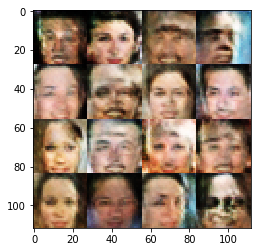

Epoch 1/1...Batch 4910 Discriminator Loss: 1.3576... Generator Loss: 0.6044
Epoch 1/1...Batch 4920 Discriminator Loss: 1.5671... Generator Loss: 0.4194
Epoch 1/1...Batch 4930 Discriminator Loss: 1.0665... Generator Loss: 1.1933
Epoch 1/1...Batch 4940 Discriminator Loss: 1.2351... Generator Loss: 0.8703
Epoch 1/1...Batch 4950 Discriminator Loss: 1.4745... Generator Loss: 0.5411
Epoch 1/1...Batch 4960 Discriminator Loss: 1.2418... Generator Loss: 0.7915
Epoch 1/1...Batch 4970 Discriminator Loss: 1.3566... Generator Loss: 0.6037
Epoch 1/1...Batch 4980 Discriminator Loss: 1.3091... Generator Loss: 0.6775
Epoch 1/1...Batch 4990 Discriminator Loss: 1.1278... Generator Loss: 1.2915
Epoch 1/1...Batch 5000 Discriminator Loss: 1.5492... Generator Loss: 0.5344


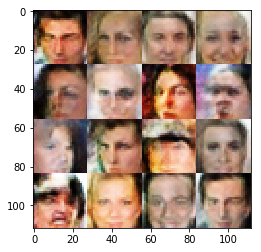

Epoch 1/1...Batch 5010 Discriminator Loss: 1.1800... Generator Loss: 0.9691
Epoch 1/1...Batch 5020 Discriminator Loss: 1.2148... Generator Loss: 0.8589
Epoch 1/1...Batch 5030 Discriminator Loss: 1.1843... Generator Loss: 1.0379
Epoch 1/1...Batch 5040 Discriminator Loss: 1.0638... Generator Loss: 0.9617
Epoch 1/1...Batch 5050 Discriminator Loss: 1.1702... Generator Loss: 1.4133
Epoch 1/1...Batch 5060 Discriminator Loss: 0.6931... Generator Loss: 1.5627
Epoch 1/1...Batch 5070 Discriminator Loss: 1.1507... Generator Loss: 1.3136
Epoch 1/1...Batch 5080 Discriminator Loss: 1.3073... Generator Loss: 0.6566
Epoch 1/1...Batch 5090 Discriminator Loss: 1.3498... Generator Loss: 0.5742
Epoch 1/1...Batch 5100 Discriminator Loss: 1.2358... Generator Loss: 0.6487


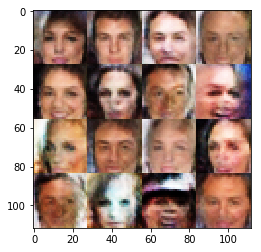

Epoch 1/1...Batch 5110 Discriminator Loss: 1.1148... Generator Loss: 1.1046
Epoch 1/1...Batch 5120 Discriminator Loss: 1.1107... Generator Loss: 0.9913
Epoch 1/1...Batch 5130 Discriminator Loss: 1.2835... Generator Loss: 0.7052
Epoch 1/1...Batch 5140 Discriminator Loss: 1.6569... Generator Loss: 0.4061
Epoch 1/1...Batch 5150 Discriminator Loss: 1.1707... Generator Loss: 0.9877
Epoch 1/1...Batch 5160 Discriminator Loss: 1.3406... Generator Loss: 0.6720
Epoch 1/1...Batch 5170 Discriminator Loss: 1.2106... Generator Loss: 0.7007
Epoch 1/1...Batch 5180 Discriminator Loss: 1.1927... Generator Loss: 0.7732
Epoch 1/1...Batch 5190 Discriminator Loss: 1.4421... Generator Loss: 0.5943
Epoch 1/1...Batch 5200 Discriminator Loss: 1.3467... Generator Loss: 1.7586


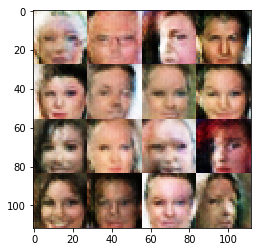

Epoch 1/1...Batch 5210 Discriminator Loss: 1.2456... Generator Loss: 0.6230
Epoch 1/1...Batch 5220 Discriminator Loss: 1.1841... Generator Loss: 1.1976
Epoch 1/1...Batch 5230 Discriminator Loss: 1.1992... Generator Loss: 0.7017
Epoch 1/1...Batch 5240 Discriminator Loss: 1.2389... Generator Loss: 0.9829
Epoch 1/1...Batch 5250 Discriminator Loss: 1.1001... Generator Loss: 0.8954
Epoch 1/1...Batch 5260 Discriminator Loss: 1.0840... Generator Loss: 0.8746
Epoch 1/1...Batch 5270 Discriminator Loss: 1.3262... Generator Loss: 0.6353
Epoch 1/1...Batch 5280 Discriminator Loss: 0.8443... Generator Loss: 1.3935
Epoch 1/1...Batch 5290 Discriminator Loss: 1.2016... Generator Loss: 1.1285
Epoch 1/1...Batch 5300 Discriminator Loss: 0.9966... Generator Loss: 1.6338


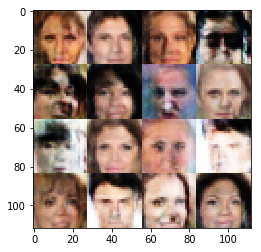

Epoch 1/1...Batch 5310 Discriminator Loss: 1.2074... Generator Loss: 0.8612
Epoch 1/1...Batch 5320 Discriminator Loss: 1.3032... Generator Loss: 0.5931
Epoch 1/1...Batch 5330 Discriminator Loss: 1.1093... Generator Loss: 0.9715
Epoch 1/1...Batch 5340 Discriminator Loss: 1.2280... Generator Loss: 0.7293
Epoch 1/1...Batch 5350 Discriminator Loss: 1.3791... Generator Loss: 0.5943
Epoch 1/1...Batch 5360 Discriminator Loss: 1.2485... Generator Loss: 0.7927
Epoch 1/1...Batch 5370 Discriminator Loss: 1.4158... Generator Loss: 0.5510
Epoch 1/1...Batch 5380 Discriminator Loss: 1.1674... Generator Loss: 0.9693
Epoch 1/1...Batch 5390 Discriminator Loss: 1.2357... Generator Loss: 0.7527
Epoch 1/1...Batch 5400 Discriminator Loss: 1.2747... Generator Loss: 0.7541


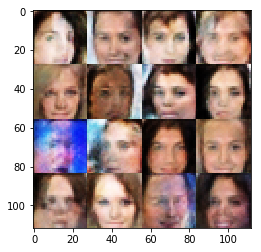

Epoch 1/1...Batch 5410 Discriminator Loss: 1.1431... Generator Loss: 0.9217
Epoch 1/1...Batch 5420 Discriminator Loss: 1.3922... Generator Loss: 1.3249
Epoch 1/1...Batch 5430 Discriminator Loss: 1.3990... Generator Loss: 0.5180
Epoch 1/1...Batch 5440 Discriminator Loss: 1.1498... Generator Loss: 1.1147
Epoch 1/1...Batch 5450 Discriminator Loss: 1.3702... Generator Loss: 0.5880
Epoch 1/1...Batch 5460 Discriminator Loss: 1.3563... Generator Loss: 0.6348
Epoch 1/1...Batch 5470 Discriminator Loss: 1.1593... Generator Loss: 0.9827
Epoch 1/1...Batch 5480 Discriminator Loss: 1.2684... Generator Loss: 1.3494
Epoch 1/1...Batch 5490 Discriminator Loss: 1.2204... Generator Loss: 0.8084
Epoch 1/1...Batch 5500 Discriminator Loss: 1.1612... Generator Loss: 0.7724


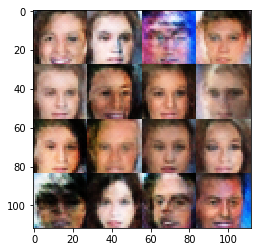

Epoch 1/1...Batch 5510 Discriminator Loss: 1.2136... Generator Loss: 0.7643
Epoch 1/1...Batch 5520 Discriminator Loss: 1.4398... Generator Loss: 0.4818
Epoch 1/1...Batch 5530 Discriminator Loss: 1.0254... Generator Loss: 0.9680
Epoch 1/1...Batch 5540 Discriminator Loss: 1.2279... Generator Loss: 0.7148
Epoch 1/1...Batch 5550 Discriminator Loss: 1.2071... Generator Loss: 0.9212
Epoch 1/1...Batch 5560 Discriminator Loss: 1.1507... Generator Loss: 0.7395
Epoch 1/1...Batch 5570 Discriminator Loss: 1.2732... Generator Loss: 0.6369
Epoch 1/1...Batch 5580 Discriminator Loss: 1.4395... Generator Loss: 0.4879
Epoch 1/1...Batch 5590 Discriminator Loss: 1.4157... Generator Loss: 0.6140
Epoch 1/1...Batch 5600 Discriminator Loss: 1.1576... Generator Loss: 0.9052


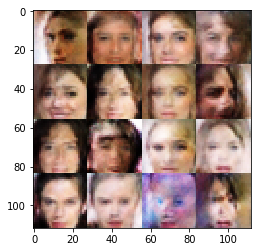

Epoch 1/1...Batch 5610 Discriminator Loss: 1.3123... Generator Loss: 0.7368
Epoch 1/1...Batch 5620 Discriminator Loss: 0.9977... Generator Loss: 1.4277
Epoch 1/1...Batch 5630 Discriminator Loss: 1.0130... Generator Loss: 0.9875
Epoch 1/1...Batch 5640 Discriminator Loss: 1.0053... Generator Loss: 1.0102
Epoch 1/1...Batch 5650 Discriminator Loss: 1.5950... Generator Loss: 0.3633
Epoch 1/1...Batch 5660 Discriminator Loss: 1.1477... Generator Loss: 0.9537
Epoch 1/1...Batch 5670 Discriminator Loss: 1.3575... Generator Loss: 0.6064
Epoch 1/1...Batch 5680 Discriminator Loss: 1.0995... Generator Loss: 1.3166
Epoch 1/1...Batch 5690 Discriminator Loss: 1.0987... Generator Loss: 1.0256
Epoch 1/1...Batch 5700 Discriminator Loss: 1.3820... Generator Loss: 0.6122


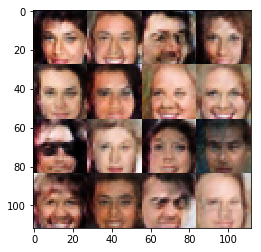

Epoch 1/1...Batch 5710 Discriminator Loss: 1.2425... Generator Loss: 0.6943
Epoch 1/1...Batch 5720 Discriminator Loss: 1.1069... Generator Loss: 0.8527
Epoch 1/1...Batch 5730 Discriminator Loss: 1.1119... Generator Loss: 0.8790
Epoch 1/1...Batch 5740 Discriminator Loss: 1.2291... Generator Loss: 0.6513
Epoch 1/1...Batch 5750 Discriminator Loss: 1.6005... Generator Loss: 1.5481
Epoch 1/1...Batch 5760 Discriminator Loss: 1.0249... Generator Loss: 1.0080
Epoch 1/1...Batch 5770 Discriminator Loss: 1.2467... Generator Loss: 0.8654
Epoch 1/1...Batch 5780 Discriminator Loss: 1.1736... Generator Loss: 0.7135
Epoch 1/1...Batch 5790 Discriminator Loss: 1.1439... Generator Loss: 1.0161
Epoch 1/1...Batch 5800 Discriminator Loss: 1.2306... Generator Loss: 0.6597


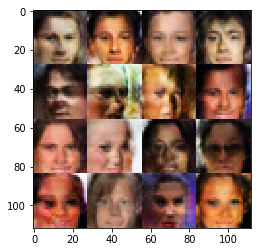

Epoch 1/1...Batch 5810 Discriminator Loss: 1.3130... Generator Loss: 0.6093
Epoch 1/1...Batch 5820 Discriminator Loss: 1.1143... Generator Loss: 1.1111
Epoch 1/1...Batch 5830 Discriminator Loss: 1.1422... Generator Loss: 0.8403
Epoch 1/1...Batch 5840 Discriminator Loss: 1.2381... Generator Loss: 0.6962
Epoch 1/1...Batch 5850 Discriminator Loss: 1.4355... Generator Loss: 0.4576
Epoch 1/1...Batch 5860 Discriminator Loss: 1.3647... Generator Loss: 1.1716
Epoch 1/1...Batch 5870 Discriminator Loss: 1.3013... Generator Loss: 0.7863
Epoch 1/1...Batch 5880 Discriminator Loss: 1.0030... Generator Loss: 0.9820
Epoch 1/1...Batch 5890 Discriminator Loss: 1.1928... Generator Loss: 1.1317
Epoch 1/1...Batch 5900 Discriminator Loss: 1.3398... Generator Loss: 0.6743


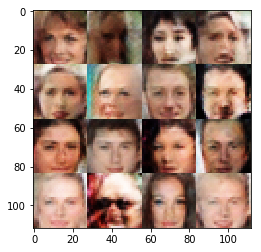

Epoch 1/1...Batch 5910 Discriminator Loss: 1.2852... Generator Loss: 0.8928
Epoch 1/1...Batch 5920 Discriminator Loss: 1.4860... Generator Loss: 0.4593
Epoch 1/1...Batch 5930 Discriminator Loss: 1.5501... Generator Loss: 0.4092
Epoch 1/1...Batch 5940 Discriminator Loss: 1.1932... Generator Loss: 0.7262
Epoch 1/1...Batch 5950 Discriminator Loss: 1.1229... Generator Loss: 0.8385
Epoch 1/1...Batch 5960 Discriminator Loss: 1.4393... Generator Loss: 0.5786
Epoch 1/1...Batch 5970 Discriminator Loss: 1.2314... Generator Loss: 0.7076
Epoch 1/1...Batch 5980 Discriminator Loss: 1.1950... Generator Loss: 0.8593
Epoch 1/1...Batch 5990 Discriminator Loss: 0.9057... Generator Loss: 1.2596
Epoch 1/1...Batch 6000 Discriminator Loss: 1.1728... Generator Loss: 0.8883


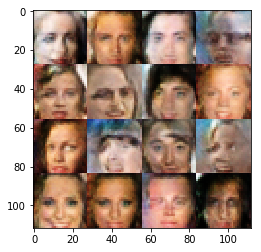

Epoch 1/1...Batch 6010 Discriminator Loss: 1.4164... Generator Loss: 0.4919
Epoch 1/1...Batch 6020 Discriminator Loss: 1.1295... Generator Loss: 0.8086
Epoch 1/1...Batch 6030 Discriminator Loss: 1.1652... Generator Loss: 0.8690
Epoch 1/1...Batch 6040 Discriminator Loss: 1.3425... Generator Loss: 1.0988
Epoch 1/1...Batch 6050 Discriminator Loss: 1.6520... Generator Loss: 0.3726
Epoch 1/1...Batch 6060 Discriminator Loss: 1.1848... Generator Loss: 0.8345
Epoch 1/1...Batch 6070 Discriminator Loss: 1.0921... Generator Loss: 0.8765
Epoch 1/1...Batch 6080 Discriminator Loss: 1.3579... Generator Loss: 0.8494
Epoch 1/1...Batch 6090 Discriminator Loss: 1.2163... Generator Loss: 0.9490
Epoch 1/1...Batch 6100 Discriminator Loss: 1.2995... Generator Loss: 0.6117


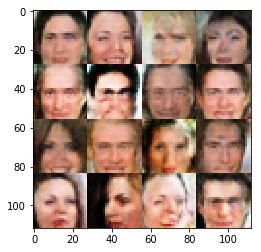

Epoch 1/1...Batch 6110 Discriminator Loss: 1.1460... Generator Loss: 0.8662
Epoch 1/1...Batch 6120 Discriminator Loss: 1.0789... Generator Loss: 1.1065
Epoch 1/1...Batch 6130 Discriminator Loss: 1.3074... Generator Loss: 0.6564
Epoch 1/1...Batch 6140 Discriminator Loss: 1.2569... Generator Loss: 0.6960
Epoch 1/1...Batch 6150 Discriminator Loss: 1.3108... Generator Loss: 0.5867
Epoch 1/1...Batch 6160 Discriminator Loss: 1.1753... Generator Loss: 0.7273
Epoch 1/1...Batch 6170 Discriminator Loss: 1.5376... Generator Loss: 0.4215
Epoch 1/1...Batch 6180 Discriminator Loss: 1.3277... Generator Loss: 0.6570
Epoch 1/1...Batch 6190 Discriminator Loss: 1.2202... Generator Loss: 0.7521
Epoch 1/1...Batch 6200 Discriminator Loss: 1.2240... Generator Loss: 0.6432


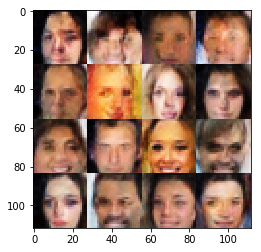

Epoch 1/1...Batch 6210 Discriminator Loss: 1.0384... Generator Loss: 0.8958
Epoch 1/1...Batch 6220 Discriminator Loss: 1.3298... Generator Loss: 0.5520
Epoch 1/1...Batch 6230 Discriminator Loss: 1.2644... Generator Loss: 1.0940
Epoch 1/1...Batch 6240 Discriminator Loss: 1.5141... Generator Loss: 0.4918
Epoch 1/1...Batch 6250 Discriminator Loss: 1.4200... Generator Loss: 0.6621
Epoch 1/1...Batch 6260 Discriminator Loss: 1.2559... Generator Loss: 0.6802
Epoch 1/1...Batch 6270 Discriminator Loss: 1.4404... Generator Loss: 0.5313
Epoch 1/1...Batch 6280 Discriminator Loss: 1.3605... Generator Loss: 0.5792
Epoch 1/1...Batch 6290 Discriminator Loss: 1.0377... Generator Loss: 1.0208
Epoch 1/1...Batch 6300 Discriminator Loss: 1.1994... Generator Loss: 0.8258


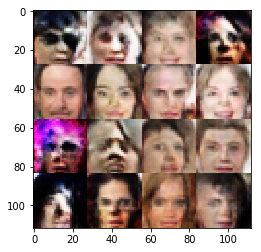

Epoch 1/1...Batch 6310 Discriminator Loss: 1.3263... Generator Loss: 0.5598
Epoch 1/1...Batch 6320 Discriminator Loss: 1.2197... Generator Loss: 0.9015
Epoch 1/1...Batch 6330 Discriminator Loss: 1.2125... Generator Loss: 0.8714


In [31]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.